## Setup

In [1]:
%load_ext autoreload
%autoreload 2

# TODo remove when packages are updated
import sys,os
sys.path.append(os.path.expanduser('~/imodels'))
sys.path.append(os.path.expanduser('~/dtreeviz'))

########################################################
# python

import os
import time
import pandas as pd
import numpy as np
import scipy.stats
norm = scipy.stats.norm
import bisect
import warnings

########################################################
# figs (imodels), xgboost, sklearn

import imodels
from imodels import FIGSClassifier
from imodels.tree.viz_utils import extract_sklearn_tree_from_figs

import xgboost as xgb

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance

########################################################
# dtreeviz
# must follow the package README to properly install all dependencies!

from dtreeviz import trees
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree
from dtreeviz.models.xgb_decision_tree import ShadowXGBDTree
from dtreeviz.colors import mpl_colors

from wand.image import Image
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

########################################################
# skompiler

from skompiler import skompile

########################################################
# plotting

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

from plotting import *

########################################################
# set global rnd_seed for reproducibility

rnd_seed = 42
np.random.seed(rnd_seed)

datasets = ['train', 'test']

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
inline=True # plot inline or to pdf
output = './output_figs_demo' # output dir
os.makedirs(output, exist_ok=True)

In [3]:
def save_dtreeviz(viz, m_path, fname, tag='', inline=inline, svg=False, png=False, pdf=True):
    if inline:
        display(viz)
    else:
        if not (svg or png or pdf):
            warnings.warn('Not saving anything!')

        os.makedirs(m_path, exist_ok=True)
        full_path = f'{m_path}/{fname}{tag}'

        # svg
        viz.save(f'{full_path}.svg')

        # pdf via svglib
        if pdf:
            renderPDF.drawToFile(svg2rlg(f'{full_path}.svg'), f'{full_path}.pdf')

        # png via wand / ImageMagick
        if png:
            img = Image(filename=f'{full_path}.svg', resolution=500)
            img.format = 'png'
            img.save(filename=f'{full_path}.png')

        if not svg:
            # clean up svg
            os.remove(f'{full_path}.svg')

        # clean up graphviz dot file (no extension)
        os.remove(full_path)

In [4]:
def save_plt(m_path, fname, tag='', inline=inline):
    plt.tight_layout()
    if inline:
        plt.show()
    else:
        os.makedirs(m_path, exist_ok=True)
        plt.savefig(f'{m_path}/{fname}{tag}.pdf')
        plt.close('all')

***
# Generate Random Data
Include additive structure that FIGS does well on

In [5]:
mc_params_all = {'n_samples': int(2e4), 'n_classes': 2, 'shuffle': False, 'shift': 0.0, 'scale': 1.0, 'hypercube': True, 'weights': [0.46], 'n_repeated': 0, 'flip_y': 0.08}

mc_params = [
    {'n_features': 15, 'n_informative': 10, 'n_redundant': 3, 'n_clusters_per_class': 2, 'class_sep': 0.4},
    {'n_features': 15, 'n_informative': 5, 'n_redundant': 2, 'n_clusters_per_class': 2, 'class_sep': 0.3},
]

X = None
y = None
feat_names = []

for i_mc_param, mc_param in enumerate(mc_params):
    param = {**mc_params_all, **mc_param, 'random_state': rnd_seed+i_mc_param}
    X_i, y_i = make_classification(**param)
    if X is None:
        X = X_i
    else:
        X = np.concatenate([X, X_i], axis=1)
    if y is None:
        y = y_i
    else:
        y = np.logical_and(y, y_i).astype(int)
    feat_names += [f'x_{i_mc_param}_{_}' for _ in range(X_i.shape[1])]
    del X_i; del y_i;

n_neg = np.where(y == 0)[0].size
n_pos = np.where(y == 1)[0].size
print(f'Class Balance: {n_pos} positive, {n_neg} negative, ratio of {n_pos/n_neg:.3}')

Class Balance: 9989 positive, 10011 negative, ratio of 0.998


Make Train, Validation, and Test Sets

In [6]:
X_trainVal, X_test, y_trainVal, y_test = train_test_split(X, y, test_size=0.15, random_state=rnd_seed, stratify=y)
del X; del y;

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.2, random_state=rnd_seed, stratify=y_trainVal)
# del X_trainVal; del y_trainVal;

***
# FIGS
Note we are not using early stopping with FIGS, so use `X_trainVal` during training to take advantage of all rows.

In [7]:
model_figs = FIGSClassifier(max_rules=30)

In [8]:
time_figs_start = time.time()
model_figs.fit(X_trainVal, y_trainVal, feature_names=feat_names);
time_figs_end = time.time()
print(f'FIGS ran in {time_figs_end-time_figs_start:.0f} seconds')

FIGS ran in 4 seconds


In [9]:
def count_splits_figs(model):
    splits = []
    for tree_ in model.trees_:
        node_counter = iter(range(1, int(1e06)))
        def _count_node(node):
            if node.left is None:
                return
            node_id=next(node_counter)
            _count_node(node.left)
            _count_node(node.right)

        _count_node(tree_)
        splits.append(next(node_counter)-1)
    return sum(splits)

n_splits_figs = count_splits_figs(model_figs)

In [10]:
print(f'FIGS used {len(model_figs.trees_)} trees and {n_splits_figs:,} splits')

FIGS used 3 trees and 30 splits


In [11]:
print(model_figs)

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree
> ------------------------------
x_1_5 <= -0.704 (Tree #0 root)
	x_1_0 <= 0.067 (split)
		x_1_6 <= -0.314 (split)
			Val: 0.825 (leaf)
			x_0_10 <= -0.046 (split)
				Val: 0.740 (leaf)
				Val: 0.562 (leaf)
		x_1_6 <= -0.202 (split)
			Val: 0.569 (leaf)
			Val: 0.258 (leaf)
	x_1_0 <= -0.464 (split)
		Val: 0.198 (leaf)
		x_1_6 <= 1.081 (split)
			Val: 0.414 (leaf)
			x_1_5 <= 0.907 (split)
				x_1_5 <= -0.020 (split)
					Val: 0.681 (leaf)
					Val: 0.435 (leaf)
				Val: 0.805 (leaf)

	+
x_0_0 <= 1.319 (Tree #1 root)
	x_0_3 <= 1.002 (split)
		x_0_8 <= -1.399 (split)
			x_0_5 <= -0.965 (split)
				Val: -0.308 (leaf)
				x_0_2 <= -0.909 (split)
					Val: -0.138 (leaf)
					Val: 0.108 (leaf)
			x_0_2 <= 0.323 (split)
				x_0_6 <= -1.245 (split)
					x_0_2 <= -0.802 (split)
						Val: -0.321 (leaf)
						Val: 0.063 (leaf)
					x_0_0 <= -2.

In [12]:
print(model_figs.print_tree(X_train, y_train))

------------
x_1_5 <= -0.704 6793/13600 (49.95%)
	x_1_0 <= 0.067 3120/4330 (72.06%)
		x_1_6 <= -0.314 2956/3827 (77.24%)
			ΔRisk = 0.82 1705/1933 (88.2%)
			x_0_10 <= -0.046 1251/1894 (66.05%)
				ΔRisk = 0.74 601/797 (75.41%)
				ΔRisk = 0.56 650/1097 (59.25%)
		x_1_6 <= -0.202 164/503 (32.6%)
			ΔRisk = 0.57 98/155 (63.23%)
			ΔRisk = 0.26 66/348 (18.97%)
	x_1_0 <= -0.464 3673/9270 (39.62%)
		ΔRisk = 0.20 492/2442 (20.15%)
		x_1_6 <= 1.081 3181/6828 (46.59%)
			ΔRisk = 0.41 2098/5179 (40.51%)
			x_1_5 <= 0.907 1083/1649 (65.68%)
				x_1_5 <= -0.020 573/1079 (53.1%)
					ΔRisk = 0.68 252/337 (74.78%)
					ΔRisk = 0.44 321/742 (43.26%)
				ΔRisk = 0.81 510/570 (89.47%)

	+
x_0_0 <= 1.319 6793/13600 (49.95%)
	x_0_3 <= 1.002 6138/11222 (54.7%)
		x_0_8 <= -1.399 4839/7855 (61.6%)
			x_0_5 <= -0.965 435/1255 (34.66%)
				ΔRisk = -0.31 47/368 (12.77%)
				x_0_2 <= -0.909 388/887 (43.74%)
					ΔRisk = -0.14 57/288 (19.79%)
					ΔRisk = 0.11 331/599 (55.26%)
			x_0_2 <= 0.323 4404/6600 (66.7

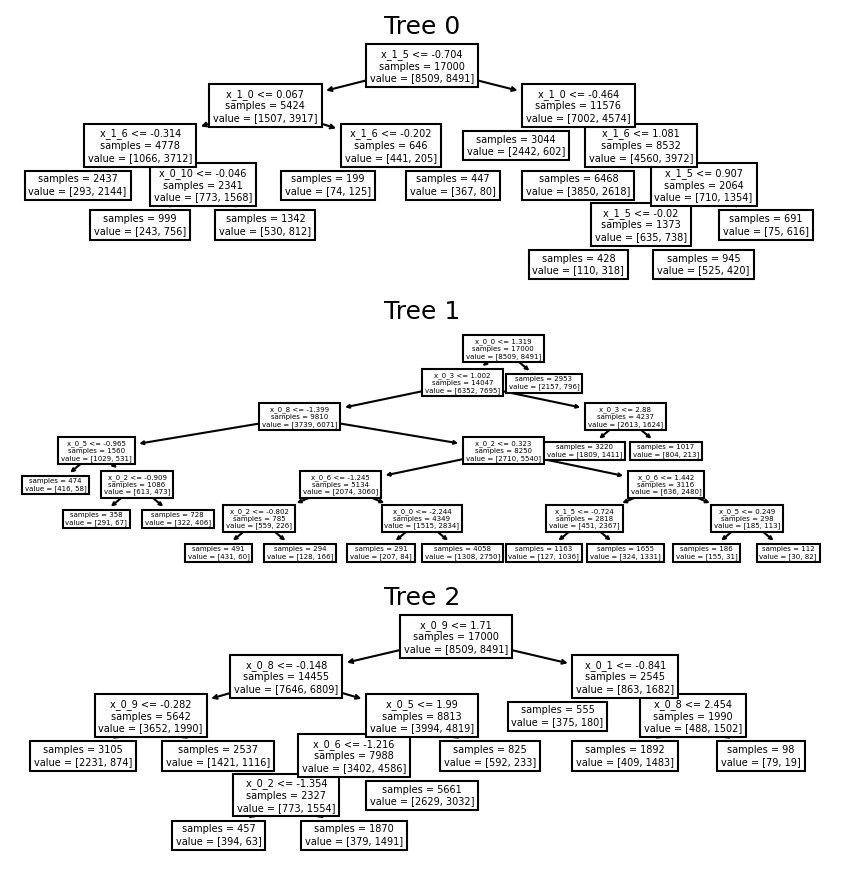

In [13]:
if inline:
    model_figs.plot(fig_size=7)

***
# XGBoost

In [14]:
params_default = {'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 1.0}

In [15]:
fixed_setup_params = {
    'max_num_boost_rounds': 100, # maximum number of boosting rounds to run / trees to create
    'xgb_objective': 'binary:logistic', # objective function for binary classification
    'xgb_verbosity': 0, #  The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    'xgb_n_jobs': -1, # Number of parallel threads used to run XGBoost. -1 makes use of all cores in your system
    'eval_metric': 'auc', # evaluation metric for early stopping
    'early_stopping_rounds': 10, # must see improvement over last num_early_stopping_rounds or will halt
}

In [16]:
fixed_fit_params = {
    'eval_set': [(X_val, y_val)], # data sets to use for early stopping evaluation
    'verbose': False, # even more verbosity control
}

In [17]:
model_xgboost = xgb.XGBClassifier(n_estimators=fixed_setup_params['max_num_boost_rounds'],
                                  objective=fixed_setup_params['xgb_objective'],
                                  verbosity=fixed_setup_params['xgb_verbosity'],
                                  eval_metric=fixed_setup_params['eval_metric'],
                                  early_stopping_rounds=fixed_setup_params['early_stopping_rounds'],
                                  random_state=rnd_seed+3, **params_default)

In [18]:
time_xgboost_start = time.time()
model_xgboost.fit(X_train, y_train, **fixed_fit_params);
model_xgboost.get_booster().feature_names = feat_names
time_xgboost_end = time.time()
print(f'XGBoost ran in {time_xgboost_end-time_xgboost_start:.0f} seconds')

XGBoost ran in 1 seconds


In [19]:
n_splits_xgboost = sum([tree.count('"split"') for tree in model_xgboost.get_booster().get_dump(dump_format='json')[0:model_xgboost.best_ntree_limit]])

In [20]:
print(f'XGBoost used {model_xgboost.best_ntree_limit} trees and {n_splits_xgboost:,} splits')

XGBoost used 64 trees and 1,496 splits


***
# Evaluate

## Setup

In [21]:
def classifier_metrics(model, model_nname, X_train, y_train, X_test, y_test, feature_names, do_permutation_importance=True, print_classification_report=False):
    model_metrics = {'nname': model_nname}
    dfp_importance = pd.DataFrame({'feature': feature_names})
    dfp_importance['icolX'] = dfp_importance.index

    for dataset in datasets[::-1]:
        if dataset == 'test':
            X = X_test
            y = y_test
        elif dataset == 'train':
            X = X_train
            y = y_train
        y_pred = model.predict(X)
        # only want positive class prob
        try:
            # use best_iteration for XGBoost
            y_pred_prob = model.predict_proba(X, iteration_range=(0, model.best_iteration+1))[:, 1]
        except:
            y_pred_prob = model.predict_proba(X)[:, 1]

        model_metrics[dataset] = {}
        model_metrics[dataset]['accuracy_score'] = metrics.accuracy_score(y, y_pred)
        model_metrics[dataset]['precision_score'] = metrics.precision_score(y, y_pred, zero_division=0) # zero_division=0 hides divide by zero warnings that come up with LR doesn't converge
        model_metrics[dataset]['recall_score'] = metrics.recall_score(y, y_pred)
        model_metrics[dataset]['f1_score'] = metrics.f1_score(y, y_pred)
        model_metrics[dataset]['roc_auc_score'] = metrics.roc_auc_score(y, y_pred_prob)
        model_metrics[dataset]['average_precision_score'] = metrics.average_precision_score(y, y_pred_prob) # PR ROC AUC
        model_metrics[dataset]['log_loss'] = metrics.log_loss(y, y_pred)
        model_metrics[dataset]['cohen_kappa_score'] = metrics.cohen_kappa_score(y, y_pred)
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        CM = metrics.confusion_matrix(y, y_pred)
        model_metrics[dataset]['confusion_matrix'] = CM
        model_metrics[dataset]['TN'] = CM[0][0]
        model_metrics[dataset]['FP'] = CM[0][1]
        model_metrics[dataset]['FN'] = CM[1][0]
        model_metrics[dataset]['TP'] = CM[1][1]
        model_metrics[dataset]['TNR'] = CM[0][0] / (CM[0][0] + CM[0][1]) # TN / (TN + FP)
        model_metrics[dataset]['NPV'] = CM[0][0] / (CM[0][0] + CM[1][0]) # TN / (TN + FN)

        model_metrics[dataset]['pop_PPV'] = len(np.where(y == 1)[0]) / len(y) # P / (P + N)

        # model_metrics[dataset]['dfp_y'] = pd.DataFrame( {'y': y, 'y_pred_prob': y_pred_prob, 'y_pred': y_pred} )

        # for LR models
        # model_converged = (model.n_iter_ < model.max_iter)[0]

        if print_classification_report:
            print(f'For {dataset}:')
            print(metrics.classification_report(y, y_pred))

        # ROC Curves
        def get_n_predicted_positive_vs_thr(y_pred_prob, thr):
            y_pred_prob_sorted = sorted(y_pred_prob)
            return [len(y_pred_prob_sorted) - bisect.bisect_left(y_pred_prob_sorted, _thr) for _thr in thr]

        fpr, tpr, thr_of_fpr_tpr = roc_curve(y, y_pred_prob)
        n_predicted_positive_vs_thr_of_fpr_tpr = get_n_predicted_positive_vs_thr(y_pred_prob, thr_of_fpr_tpr)
        dfp_eval_fpr_tpr = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thr': thr_of_fpr_tpr, 'n_predicted_positive': n_predicted_positive_vs_thr_of_fpr_tpr}).sort_values(by='thr').reset_index(drop=True)

        precision, recall, thr_of_precision_recall = precision_recall_curve(y, y_pred_prob)
        thr_of_precision_recall = np.insert(thr_of_precision_recall, 0, [0])
        n_predicted_positive_vs_thr_of_precision_recall = get_n_predicted_positive_vs_thr(y_pred_prob, thr_of_precision_recall)
        dfp_eval_precision_recall = pd.DataFrame({'precision': precision, 'recall': recall, 'thr': thr_of_precision_recall, 'n_predicted_positive': n_predicted_positive_vs_thr_of_precision_recall})
        dfp_eval_precision_recall['f1'] = 2*(dfp_eval_precision_recall['precision'] * dfp_eval_precision_recall['recall']) / (dfp_eval_precision_recall['precision'] + dfp_eval_precision_recall['recall'])

        model_metrics[dataset]['dfp_eval_fpr_tpr'] = dfp_eval_fpr_tpr
        model_metrics[dataset]['dfp_eval_precision_recall'] = dfp_eval_precision_recall

        roc_entry = {'name': f'{model_nname.lower()}_{dataset}',
                     'nname': f'{model_nname} ({dataset.title()})',
                     'dfp_eval_fpr_tpr': dfp_eval_fpr_tpr,
                     'dfp_eval_precision_recall': dfp_eval_precision_recall
                    }
        if dataset == 'test':
            roc_entry['c'] = 'C2'
            roc_entry['ls'] = '-'
        else:
            roc_entry['c'] = 'black'
            roc_entry['ls'] = ':'

        model_metrics[dataset]['roc_entry'] = roc_entry

        if do_permutation_importance:
            # print('Start do_permutation_importance func')
            # Permutation feature importance
            # slow for thousands of features!
            # https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
            # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
            # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
            # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
            _permutation_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc')
            # print('End permutation_importance func')

            importance_permutation_mean = _permutation_importance['importances_mean']
            importance_permutation_std = _permutation_importance['importances_std']
            dfp_importance_permutation = pd.DataFrame({f'importance_permutation_{dataset}_mean': importance_permutation_mean, f'importance_permutation_{dataset}_std': importance_permutation_std})
            dfp_importance_permutation['icolX'] = dfp_importance_permutation.index
            dfp_importance_permutation[f'importance_permutation_{dataset}_pct'] = dfp_importance_permutation[f'importance_permutation_{dataset}_mean'].rank(pct=True)
            dfp_importance = pd.merge(dfp_importance, dfp_importance_permutation, on='icolX', how='left')

    # for LR models
    # dfp_coef = pd.DataFrame({'coefficients': model.coef_[0]})
    # dfp_coef['abs_coeff'] = dfp_coef['coefficients'].abs()
    # dfp_coef['icolX'] = dfp_coef.index
    # dfp_importance = pd.merge(dfp_importance, dfp_coef, on='icolX', how='left')

    # TODO
    # Gini impurity importance - a mean decrease in impurity (MDI) importance (both RF and BDT)
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_
    # importances_gini = model.feature_importances_
    # estimators = model.estimators_
    # importances_gini_std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    # dfp_importance_gini = pd.DataFrame({'importance_gini': importances_gini, 'importance_gini_std': importances_gini_std})
    # dfp_importance_gini['icolX'] = dfp_importance_gini.index
    # dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)
    # dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='icolX', how='left')

    target_cols_importance = [
        'feature',
        # 'coefficients',
        'importance_permutation_test_mean',
        'importance_permutation_test_std',
        'importance_permutation_test_pct',
        'importance_permutation_train_mean',
        'importance_permutation_train_std',
        'importance_permutation_train_pct',
        # 'importance_gini',
        # 'importance_gini_std',
        # 'importance_gini_pct',
        'icolX',
        # 'abs_coeff',
    ]
    _cols = [_col for _col in target_cols_importance if _col in dfp_importance.columns] + [_col for _col in dfp_importance.columns if _col not in target_cols_importance]
    dfp_importance = dfp_importance[_cols]
    if 'importance_permutation_test_mean' in dfp_importance.columns:
        sort_col = 'importance_permutation_test_mean'
    elif 'importance_gini' in dfp_importance.columns:
        sort_col = 'importance_gini'
    else:
        sort_col = 'icolX'
    dfp_importance = dfp_importance.sort_values(by=sort_col, ascending=False).reset_index(drop=True)

    dfp_importance = dfp_importance.drop(['icolX'], axis=1)
    # if 'abs_coeff' in dfp_importance.columns:
    #     dfp_importance = dfp_importance.drop(['abs_coeff'], axis=1)

    model_metrics['dfp_importance'] = dfp_importance

    return model_metrics

## Metrics

In [22]:
model_metrics_figs = classifier_metrics(model_figs, 'FIGS', X_trainVal, y_trainVal, X_test, y_test, feat_names)
model_metrics_xgboost = classifier_metrics(model_xgboost, 'XGBoost', X_train, y_train, X_test, y_test, feat_names)

metric_rows = []
for model_metrics in [model_metrics_figs, model_metrics_xgboost]:
    roc_entries = []
    for idataset,dataset in enumerate(datasets[::-1]):
        dataset_metrics = {'model': model_metrics['nname'], 'dataset': dataset}
        for k,v in model_metrics[dataset].items():
            if k == 'roc_entry':
                v = v.copy()
                if 0 < len(roc_entries):
                    v['name'] = dataset
                roc_entries.append(v)
            elif k not in ['confusion_matrix', 'dfp_eval_fpr_tpr', 'dfp_eval_precision_recall', 'dfp_y']:
                dataset_metrics[k] = v
        metric_rows.append(dataset_metrics)

    plot_rocs(roc_entries, m_path=f'{output}/roc_curves', rndGuess=False, inverse_log=False, inline=False)
    plot_rocs(roc_entries, m_path=f'{output}/roc_curves', rndGuess=False, inverse_log=False, precision_recall=True,
              pop_PPV=model_metrics['test']['pop_PPV'], y_axis_params={'min': -0.05}, inline=False)

dfp_metrics = pd.DataFrame(metric_rows)
dfp_metrics = dfp_metrics.sort_values(by=['model', 'dataset'], ascending=[True, True]).reset_index(drop=True)
display(dfp_metrics)

model dataset  accuracy_score  precision_score  recall_score  f1_score  \
0     FIGS    test        0.791333         0.779129      0.812417  0.795425   
1     FIGS   train        0.801765         0.790010      0.821458  0.805427   
2  XGBoost    test        0.888333         0.880314      0.898531  0.889329   
3  XGBoost   train        0.942647         0.924347      0.964081  0.943796   

   roc_auc_score  average_precision_score  log_loss  cohen_kappa_score    TN  \
0       0.859606                 0.831385  7.207183           0.582690  1157   
1       0.874315                 0.854583  6.846892           0.603546  6655   
2       0.938575                 0.909339  3.856879           0.776672  1319   
3       0.983874                 0.981017  1.980932           0.885299  6271   

     FP    FN    TP       TNR       NPV   pop_PPV  
0   345   281  1217  0.770306  0.804590  0.499333  
1  1854  1516  6975  0.782113  0.814466  0.499471  
2   183   152  1346  0.878162  0.896669  0.499333  
3   536   244  6549  0.921258  0.962548  0.499485

In [23]:
roc_auc_score_figs = model_metrics_figs['test']['roc_auc_score']
roc_auc_score_xgboost = model_metrics_xgboost['test']['roc_auc_score']
print(f'ROC FIGS = {roc_auc_score_figs:.3}, XGBoost = {roc_auc_score_xgboost:.3}\nDiff = {roc_auc_score_figs-roc_auc_score_xgboost:.3}, Percent Diff = {(roc_auc_score_figs-roc_auc_score_xgboost)/roc_auc_score_xgboost:.1%}\n')
print(f'XGBoost used {n_splits_xgboost:,} splits vs FIGS {n_splits_figs:,}\nThat is {n_splits_xgboost-n_splits_figs:,}, or {(n_splits_xgboost-n_splits_figs)/n_splits_figs:,.0%}, more splits!')

ROC FIGS = 0.86, XGBoost = 0.939
Diff = -0.079, Percent Diff = -8.4%

XGBoost used 1,496 splits vs FIGS 30
That is 1,466, or 4,887%, more splits!


## Feature Importances

In [24]:
print('FIGS Feature Importances')
_dfp = model_metrics_figs['dfp_importance']
display(_dfp.loc[0 < _dfp['importance_permutation_test_mean']])

FIGS Feature Importances


feature  importance_permutation_test_mean  importance_permutation_test_std  \
0    x_1_5                          0.123099                         0.005026   
1    x_0_2                          0.067394                         0.005449   
2    x_0_8                          0.054484                         0.002915   
3    x_1_0                          0.052550                         0.003648   
4    x_0_6                          0.041602                         0.002047   
5    x_0_0                          0.039183                         0.004386   
6    x_1_6                          0.029407                         0.002986   
7    x_0_9                          0.023359                         0.002168   
8    x_0_3                          0.022293                         0.004021   
9    x_0_5                          0.016216                         0.001170   
10   x_0_1                          0.005506                         0.001437   
11  x_0_10                          0.003720                         0.000948   

    importance_permutation_test_pct  importance_permutation_train_mean  \
0                          1.000000                           0.130701   
1                          0.966667                           0.065027   
2                          0.933333                           0.045152   
3                          0.900000                           0.050321   
4                          0.866667                           0.042039   
5                          0.833333                           0.040978   
6                          0.800000                           0.027493   
7                          0.766667                           0.024342   
8                          0.733333                           0.029172   
9                          0.700000                           0.015651   
10                         0.666667                           0.005700   
11                         0.633333                           0.003339   

    importance_permutation_train_std  importance_permutation_train_pct  
0                           0.003434                          1.000000  
1                           0.001408                          0.966667  
2                           0.001012                          0.900000  
3                           0.001283                          0.933333  
4                           0.001369                          0.866667  
5                           0.001693                          0.833333  
6                           0.000879                          0.766667  
7                           0.000868                          0.733333  
8                           0.000992                          0.800000  
9                           0.000822                          0.700000  
10                          0.000395                          0.666667  
11                          0.000422                          0.633333

In [25]:
print('XGBoost Feature Importances')
_dfp = model_metrics_xgboost['dfp_importance']
display(_dfp.loc[0 < _dfp['importance_permutation_test_mean']])

XGBoost Feature Importances


feature  importance_permutation_test_mean  importance_permutation_test_std  \
0    x_0_2                          0.048694                         0.002488   
1    x_1_5                          0.046828                         0.003015   
2    x_0_6                          0.029839                         0.002065   
3    x_0_8                          0.024508                         0.001891   
4    x_1_0                          0.019697                         0.001723   
5    x_0_0                          0.016741                         0.001920   
6    x_0_5                          0.012491                         0.000688   
7    x_1_6                          0.011257                         0.001142   
8    x_0_1                          0.009089                         0.001022   
9    x_0_9                          0.008396                         0.001260   
10   x_0_7                          0.007716                         0.001321   
11  x_0_12                          0.007339                         0.001367   
12   x_1_3                          0.006692                         0.000477   
13   x_0_3                          0.005692                         0.001307   
14   x_1_1                          0.005384                         0.000935   
15   x_0_4                          0.004714                         0.000651   
16   x_1_2                          0.004160                         0.000614   
17   x_1_4                          0.003260                         0.000678   
18  x_0_11                          0.002058                         0.000480   
19  x_0_10                          0.000823                         0.000272   
20  x_0_14                          0.000578                         0.000319   
21   x_1_7                          0.000375                         0.000183   
22   x_1_8                          0.000316                         0.000238   
23   x_1_9                          0.000259                         0.000139   
24  x_1_14                          0.000213                         0.000331   
25  x_1_12                          0.000060                         0.000431   

    importance_permutation_test_pct  importance_permutation_train_mean  \
0                          1.000000                           0.043601   
1                          0.966667                           0.045275   
2                          0.933333                           0.024556   
3                          0.900000                           0.018603   
4                          0.866667                           0.016197   
5                          0.833333                           0.017729   
6                          0.800000                           0.011464   
7                          0.766667                           0.008646   
8                          0.733333                           0.007939   
9                          0.700000                           0.007243   
10                         0.666667                           0.007829   
11                         0.633333                           0.006086   
12                         0.600000                           0.005384   
13                         0.566667                           0.006381   
14                         0.533333                           0.003762   
15                         0.500000                           0.004764   
16                         0.466667                           0.004569   
17                         0.433333                           0.003655   
18                         0.400000                           0.003144   
19                         0.366667                           0.001606   
20                         0.333333                           0.001693   
21                         0.300000                           0.001640   
22                         0.266667                           0.001496   
23                         0.233333    

## ROC Curves

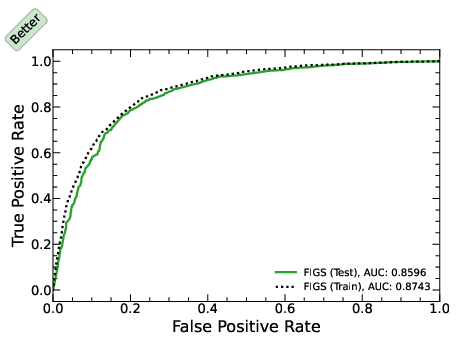

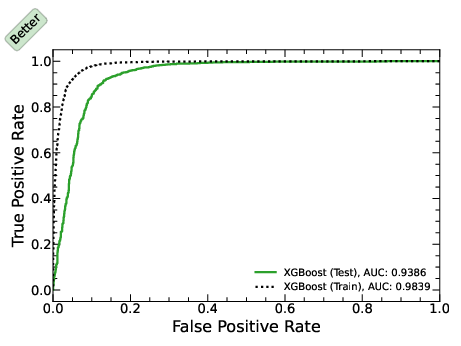

In [26]:
for dataset in datasets[::-1]:
    roc_entry_figs = model_metrics_figs[dataset]['roc_entry']
    roc_entry_figs['c'] = 'C0'
    roc_entry_figs['ls'] = '--'
    roc_entry_xgboost = model_metrics_xgboost[dataset]['roc_entry']
    roc_entry_xgboost['c'] = 'C1'
    roc_entry_xgboost['ls'] = ':'

    models_for_roc = [roc_entry_figs, roc_entry_xgboost]
    plot_rocs(models_for_roc, m_path=f'{output}/roc_curves', rndGuess=False, inverse_log=False, inline=False)
    plot_rocs(models_for_roc, m_path=f'{output}/roc_curves', rndGuess=False, inverse_log=False, precision_recall=True,
              pop_PPV=model_metrics_figs[dataset]['pop_PPV'], y_axis_params={'min': -0.05}, inline=False)

if inline:
    for fname in ['roc_figs_test_xgboost_test', 'roc_figs_test_train', 'roc_xgboost_test_train']:
        img = Image(filename=f'{output}/roc_curves/{fname}.pdf')
        display(img)

***
# Tree Plots

In [27]:
color_params = {'classes': mpl_colors, 'hist_bar': 'C0', 'legend_edge': None}
for _ in ['axis_label', 'title', 'legend_title', 'text', 'arrow', 'node_label', 'tick_label', 'leaf_label', 'wedge', 'text_wedge']:
    color_params[_] = 'black'
dtv_params_gen = {'colors': color_params, 'fontname': 'Arial'} # 'fontname': 'Helvetica'
dtv_params = {'leaf_plot_type': 'barh', 'all_axes_spines': False, 'label_fontsize': 10, 'colors': dtv_params_gen['colors'], 'fontname': dtv_params_gen['fontname']}

In [28]:
x_example = X_train[13]
feature_to_look_at_in_detail = 'x_1_5'

In [29]:
pd.DataFrame([{col: value for col,value in zip(feat_names, x_example)}])

x_0_0     x_0_1     x_0_2     x_0_3     x_0_4    x_0_5     x_0_6  \
0 -1.468936  1.046798 -1.626455 -1.970529 -0.245411  0.56924 -0.786314   

     x_0_7     x_0_8     x_0_9  ...     x_1_5     x_1_6     x_1_7     x_1_8  \
0 -1.75251  0.398451  0.978228  ... -0.081537 -0.155792 -2.416103 -1.772248   

      x_1_9    x_1_10    x_1_11    x_1_12    x_1_13    x_1_14  
0  0.312671  1.371705  0.225256 -0.635589 -1.375932 -2.365278  

[1 rows x 30 columns]

## FIGS

In [30]:
dt_figs_0 = extract_sklearn_tree_from_figs(model_figs, tree_num=0, n_classes=2)
shadow_figs_0 = ShadowSKDTree(dt_figs_0, X_train, y_train, feat_names, 'y', [0, 1])

dt_figs_1 = extract_sklearn_tree_from_figs(model_figs, tree_num=1, n_classes=2)
shadow_figs_1 = ShadowSKDTree(dt_figs_1, X_train, y_train, feat_names, 'y', [0, 1])

dt_figs_2 = extract_sklearn_tree_from_figs(model_figs, tree_num=2, n_classes=2)
shadow_figs_2 = ShadowSKDTree(dt_figs_2, X_train, y_train, feat_names, 'y', [0, 1])

### Trees

#### Split Hists

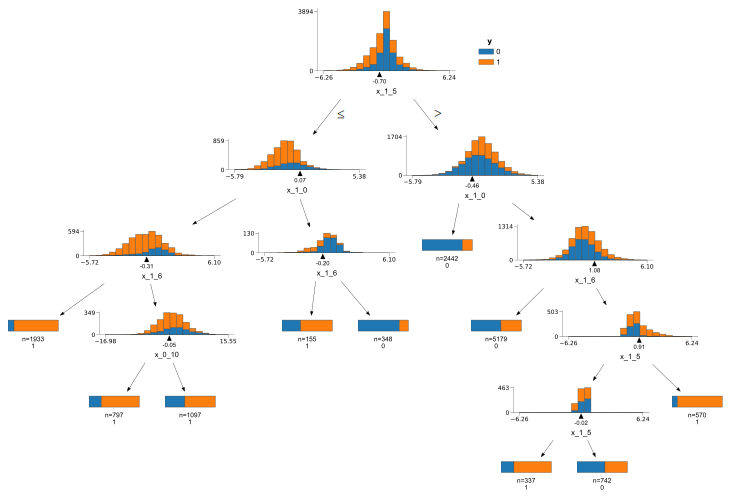

In [31]:
viz = trees.dtreeviz(shadow_figs_0, **dtv_params)
save_dtreeviz(viz, output, 'dtreeviz_figs_0')

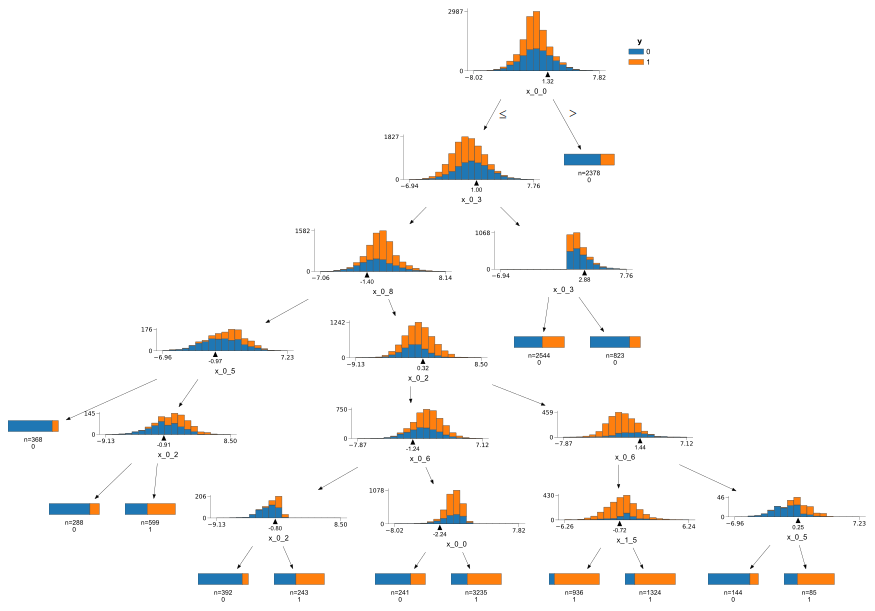

In [32]:
viz = trees.dtreeviz(shadow_figs_1, **dtv_params)
save_dtreeviz(viz, output, 'dtreeviz_figs_1')

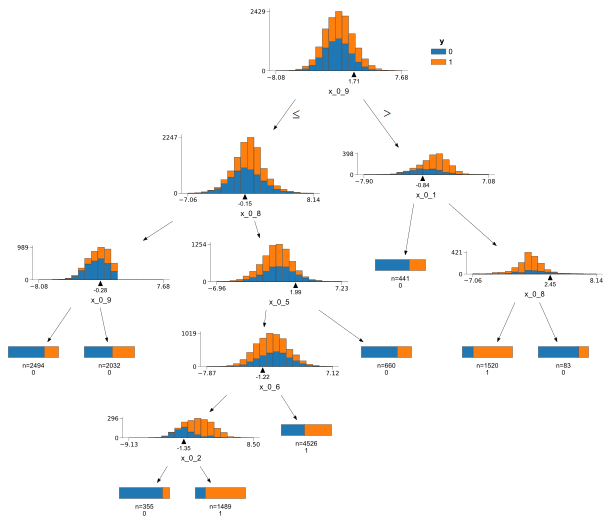

In [33]:
viz = trees.dtreeviz(shadow_figs_2, **dtv_params)
save_dtreeviz(viz, output, 'dtreeviz_figs_2')

#### Text

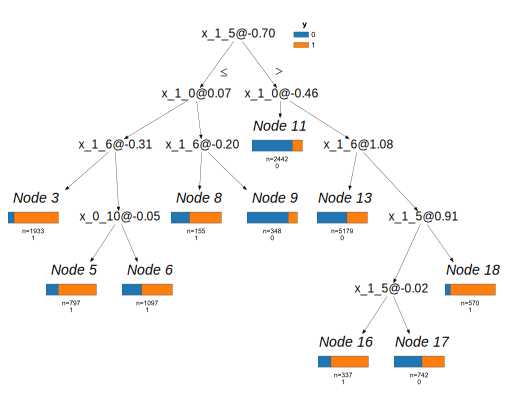

In [34]:
viz = trees.dtreeviz(shadow_figs_0, **dtv_params, fancy=False, show_node_labels=True)
save_dtreeviz(viz, output, 'dtreeviz_text_figs_0')

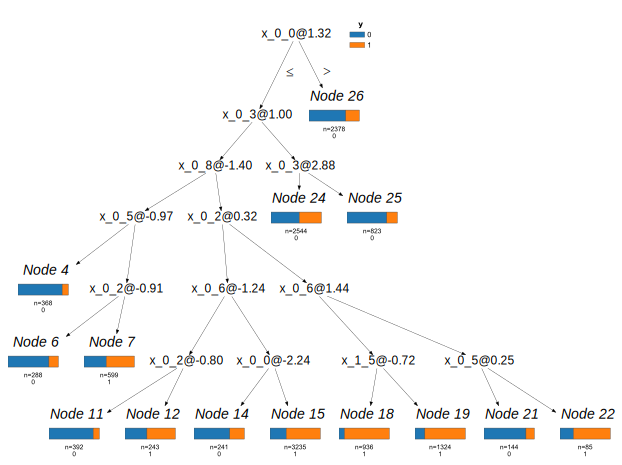

In [35]:
viz = trees.dtreeviz(shadow_figs_1, **dtv_params, fancy=False, show_node_labels=True)
save_dtreeviz(viz, output, 'dtreeviz_text_figs_1')

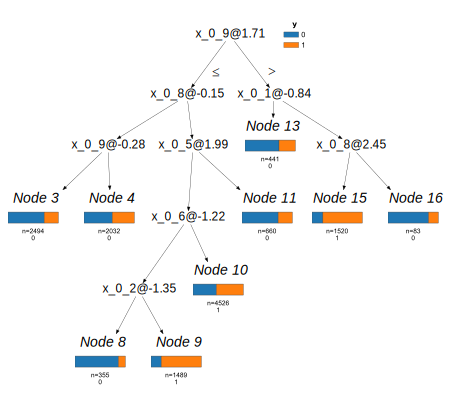

In [36]:
viz = trees.dtreeviz(shadow_figs_2, **dtv_params, fancy=False, show_node_labels=True)
save_dtreeviz(viz, output, 'dtreeviz_text_figs_2')

### Prediction Path

In [37]:
print(trees.explain_prediction_path(shadow_figs_0, x=x_example, explanation_type='plain_english'))

-0.46 <= x_1_0 
-0.7 <= x_1_5 
x_1_6 < 1.08



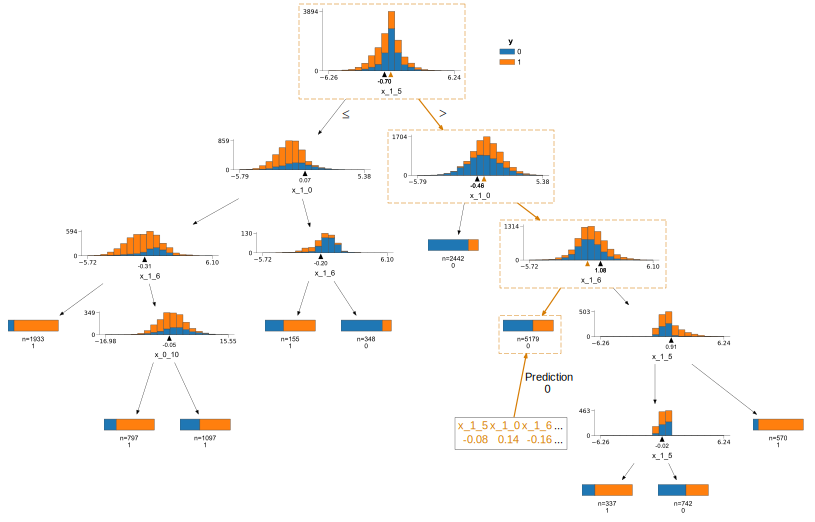

In [38]:
viz = trees.dtreeviz(shadow_figs_0, **dtv_params, X=x_example)
save_dtreeviz(viz, output, 'dtreeviz_pred_path_figs_0')

In [39]:
print(trees.explain_prediction_path(shadow_figs_1, x=x_example, explanation_type='plain_english'))

-2.24 <= x_0_0  < 1.32
x_0_2 < 0.32
x_0_3 < 1.0
-1.24 <= x_0_6 
-1.4 <= x_0_8 



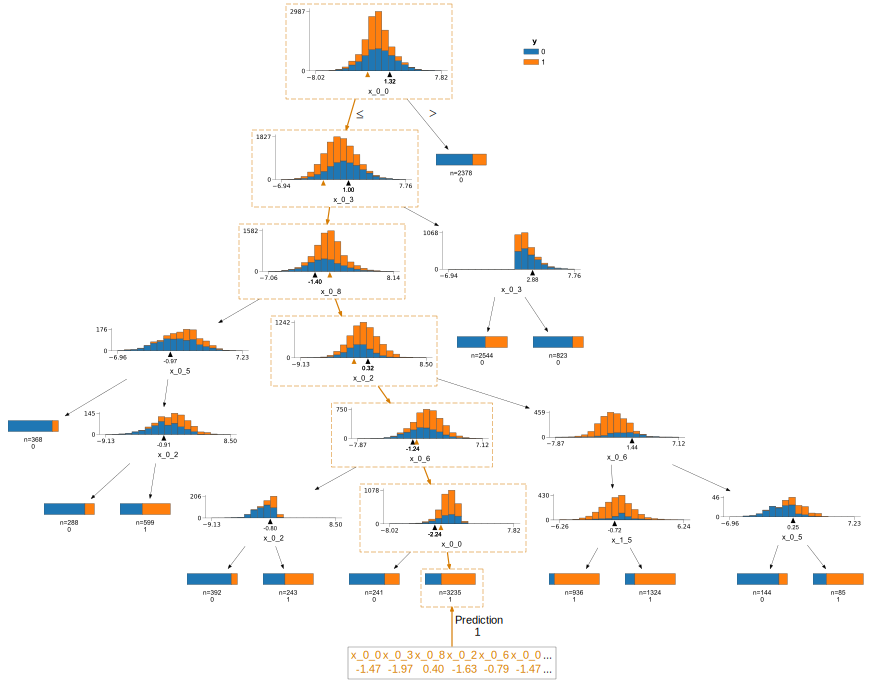

In [40]:
viz = trees.dtreeviz(shadow_figs_1, **dtv_params, X=x_example)
save_dtreeviz(viz, output, 'dtreeviz_pred_path_figs_1')

In [41]:
print(trees.explain_prediction_path(shadow_figs_2, x=x_example, explanation_type='plain_english'))

x_0_5 < 1.99
-1.22 <= x_0_6 
-0.15 <= x_0_8 
x_0_9 < 1.71



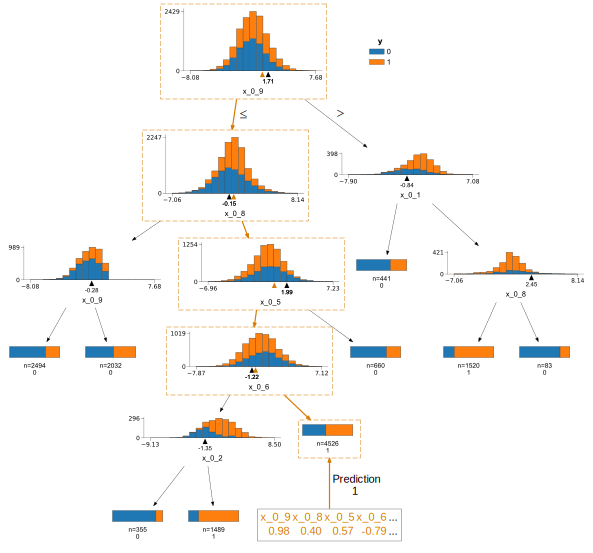

In [42]:
viz = trees.dtreeviz(shadow_figs_2, **dtv_params, X=x_example)
save_dtreeviz(viz, output, 'dtreeviz_pred_path_figs_2')

### Leaf Samples

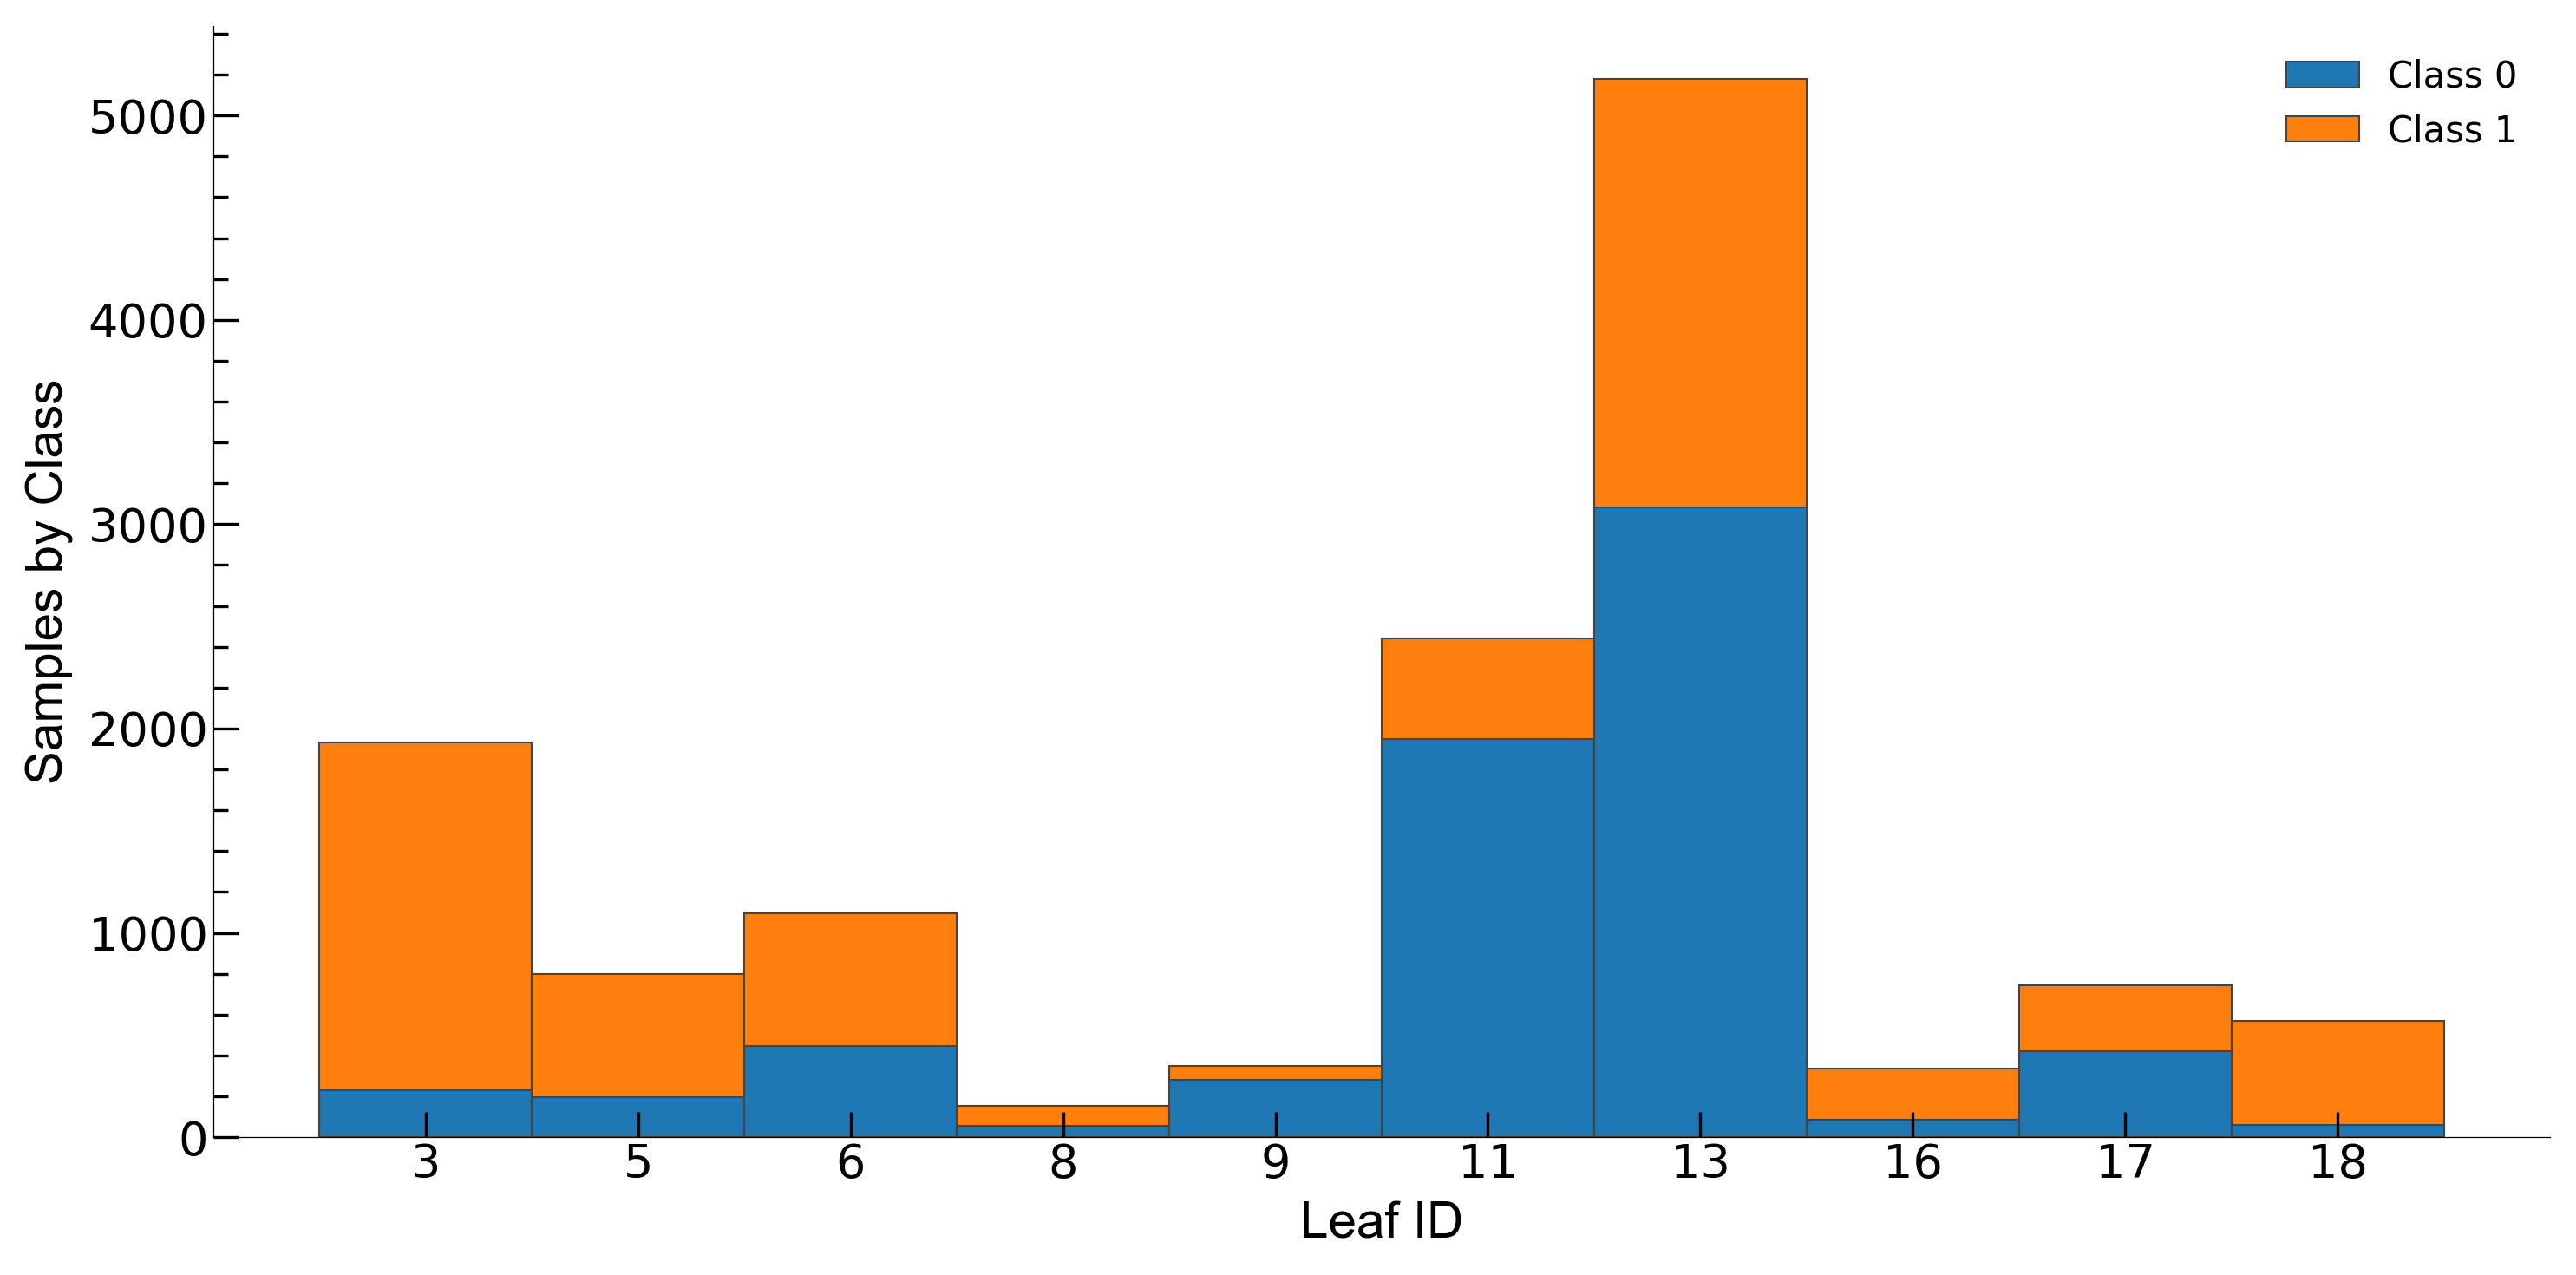

In [43]:
trees.ctreeviz_leaf_samples(shadow_figs_0, **dtv_params_gen)
save_plt(output, 'ctreeviz_leaf_samples_figs_0')

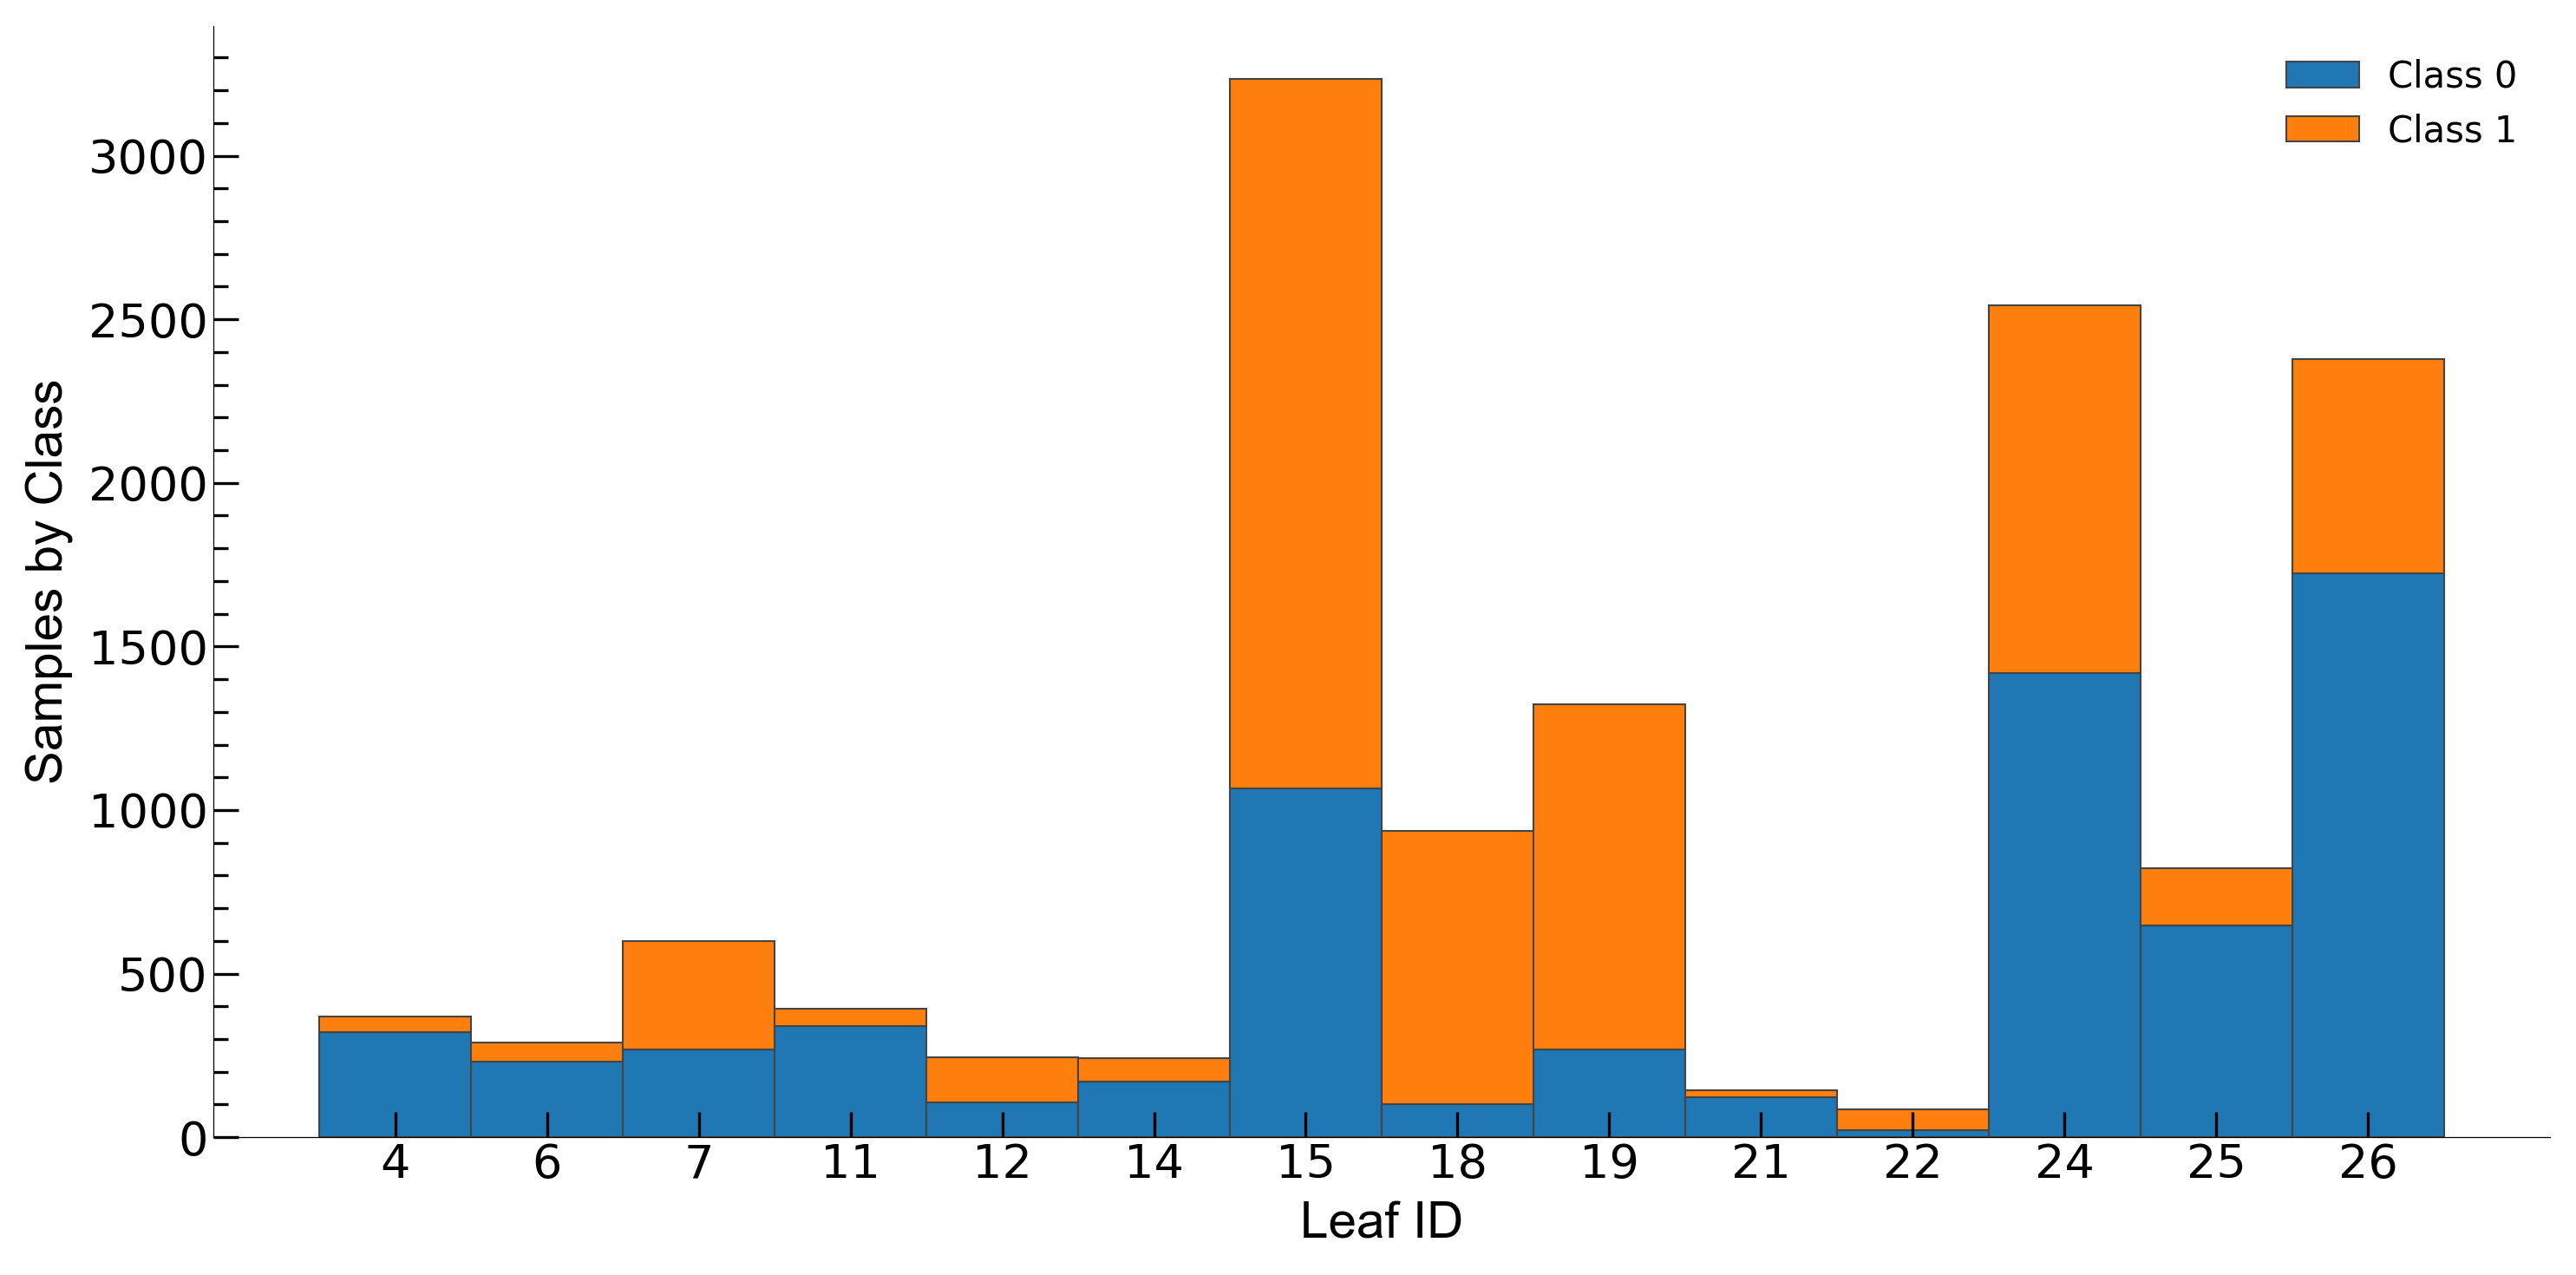

In [44]:
trees.ctreeviz_leaf_samples(shadow_figs_1, **dtv_params_gen)
save_plt(output, 'ctreeviz_leaf_samples_figs_1')

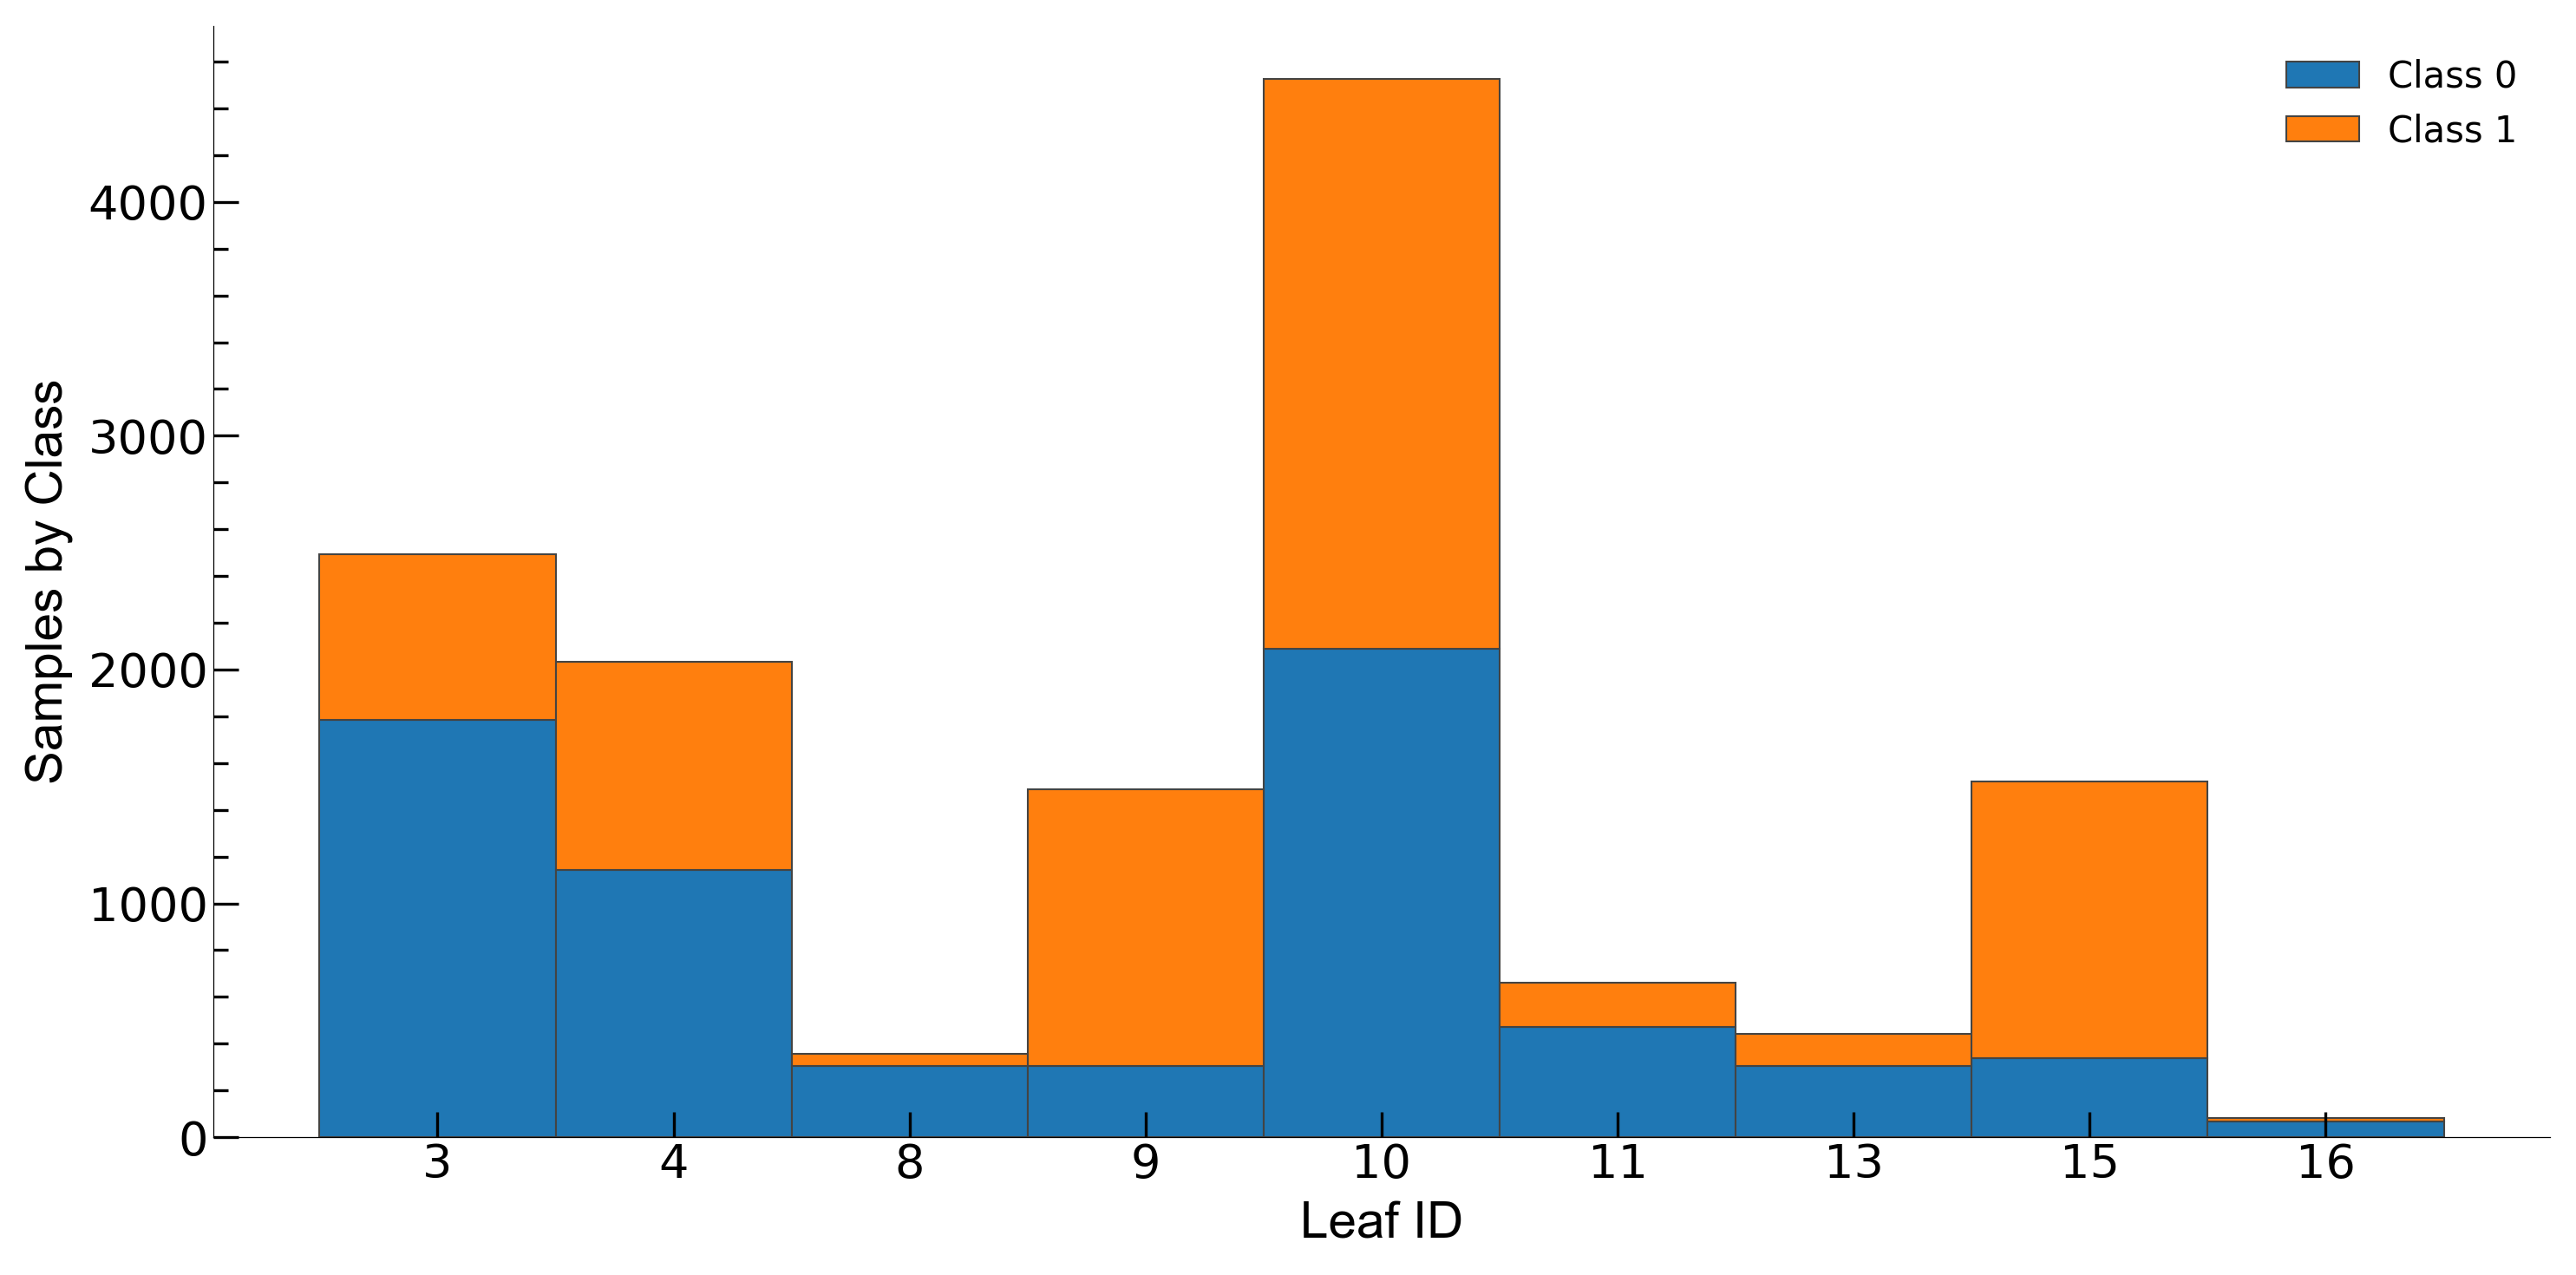

In [45]:
trees.ctreeviz_leaf_samples(shadow_figs_2, **dtv_params_gen)
save_plt(output, 'ctreeviz_leaf_samples_figs_2')

### Leaf Criterion

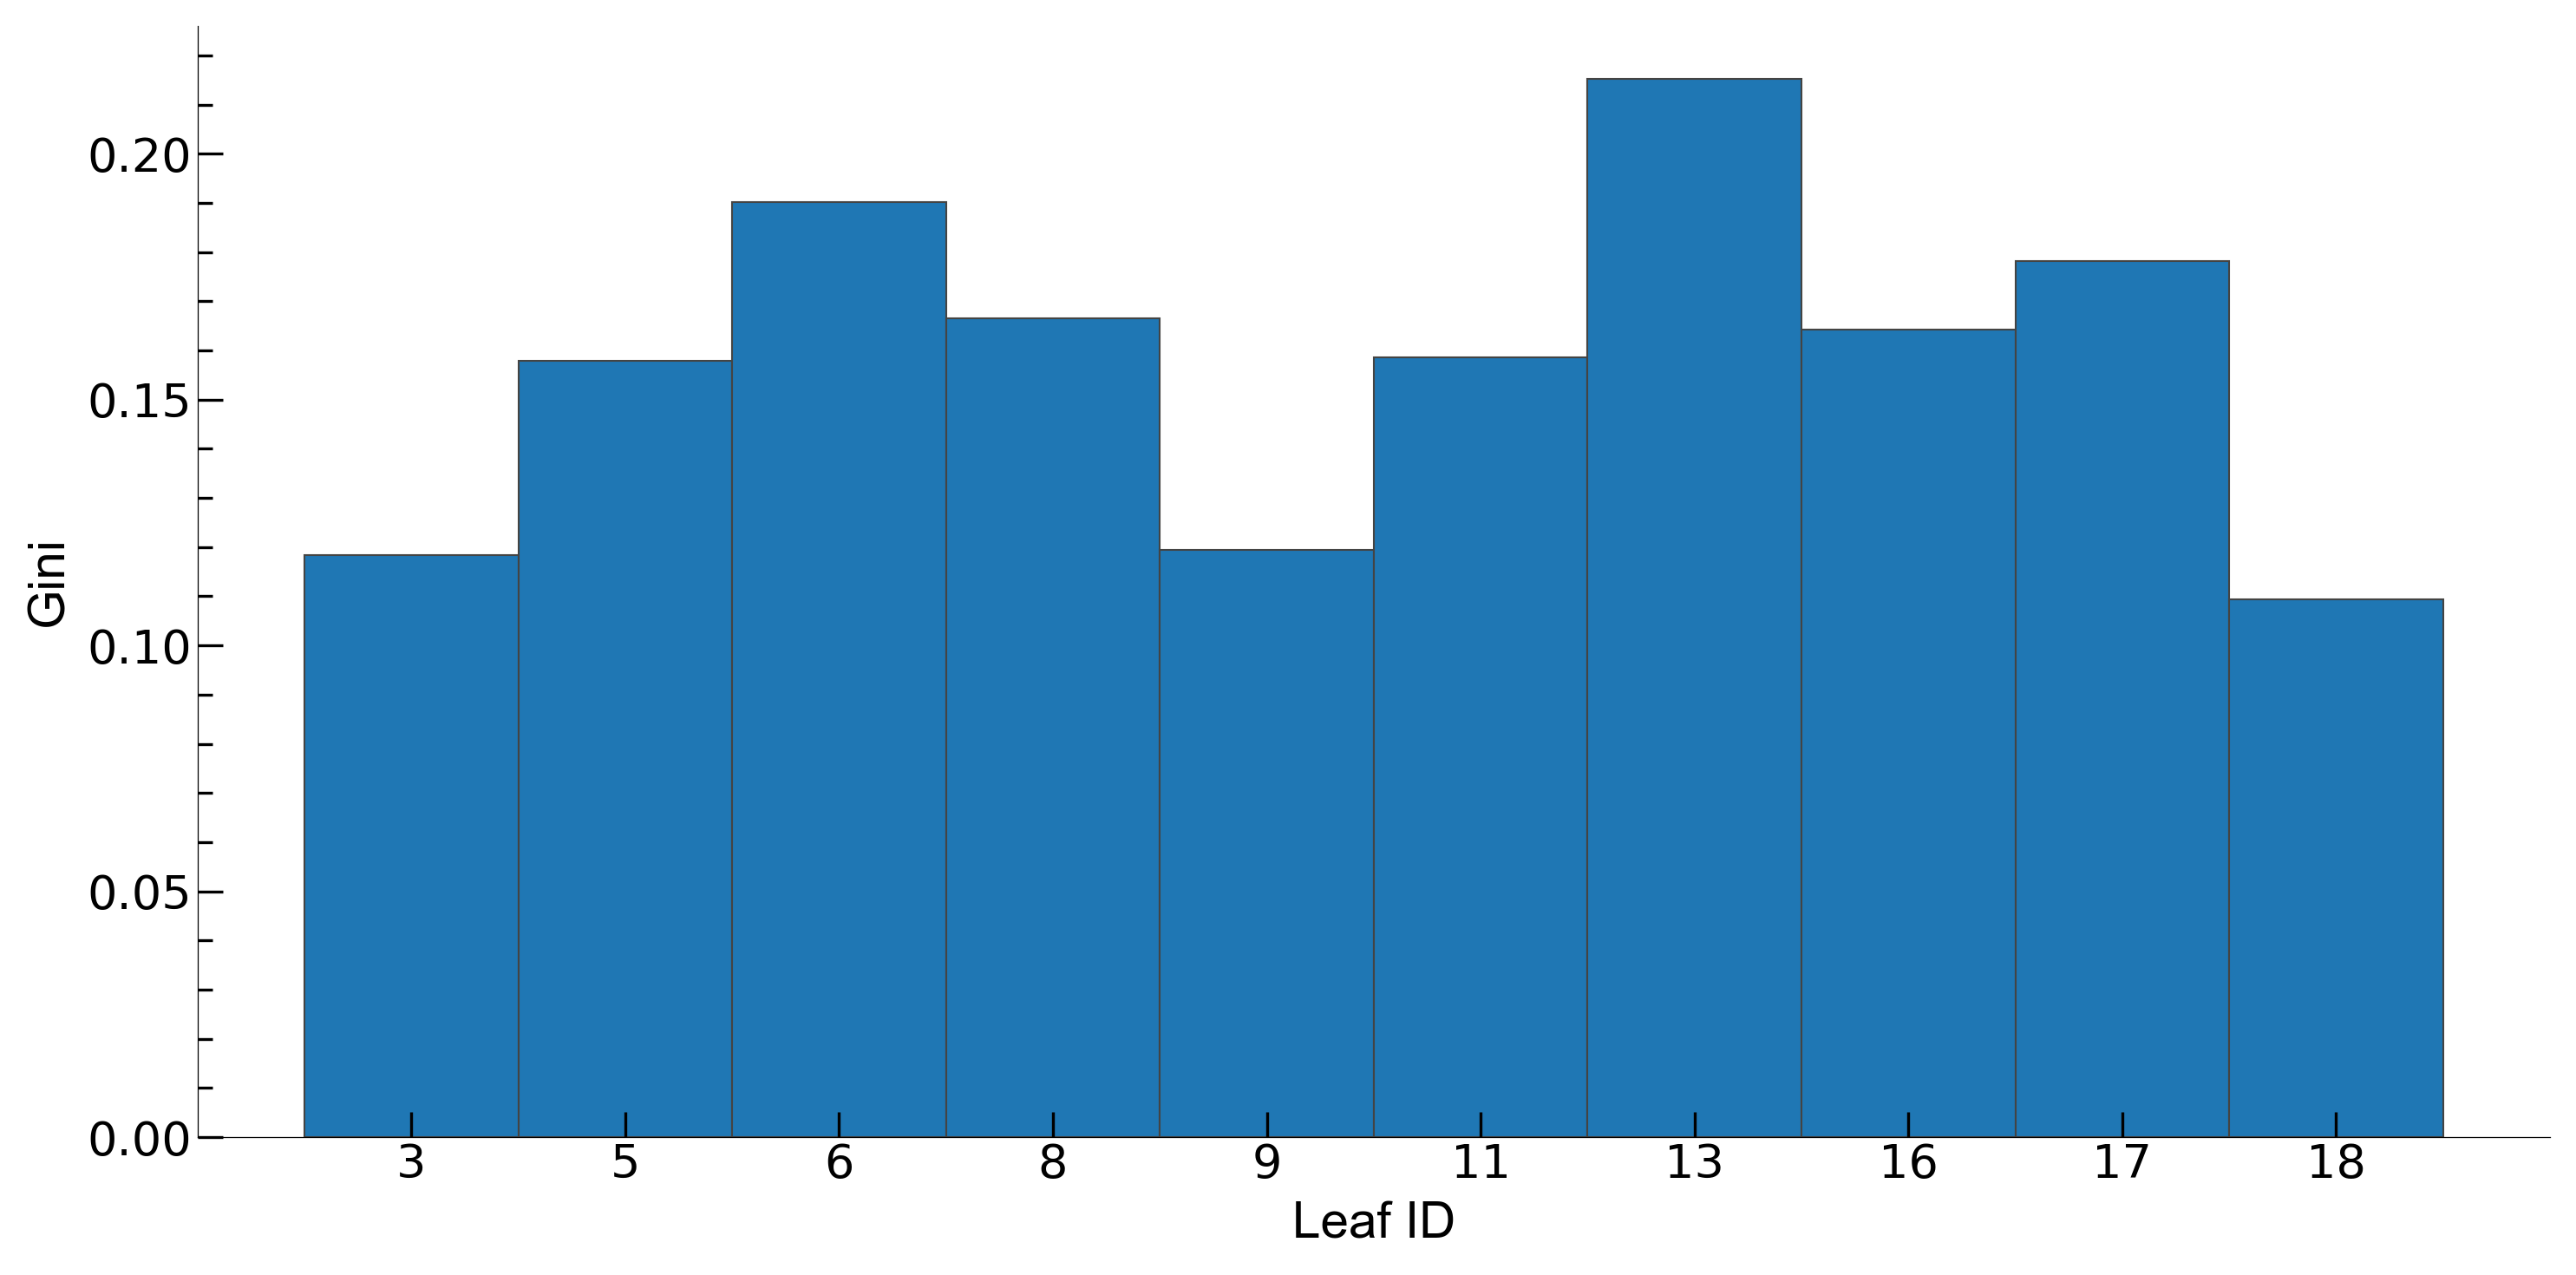

In [46]:
trees.viz_leaf_criterion(shadow_figs_0, display_type='plot', **dtv_params_gen)
save_plt(output, 'viz_leaf_criterion_figs_0')

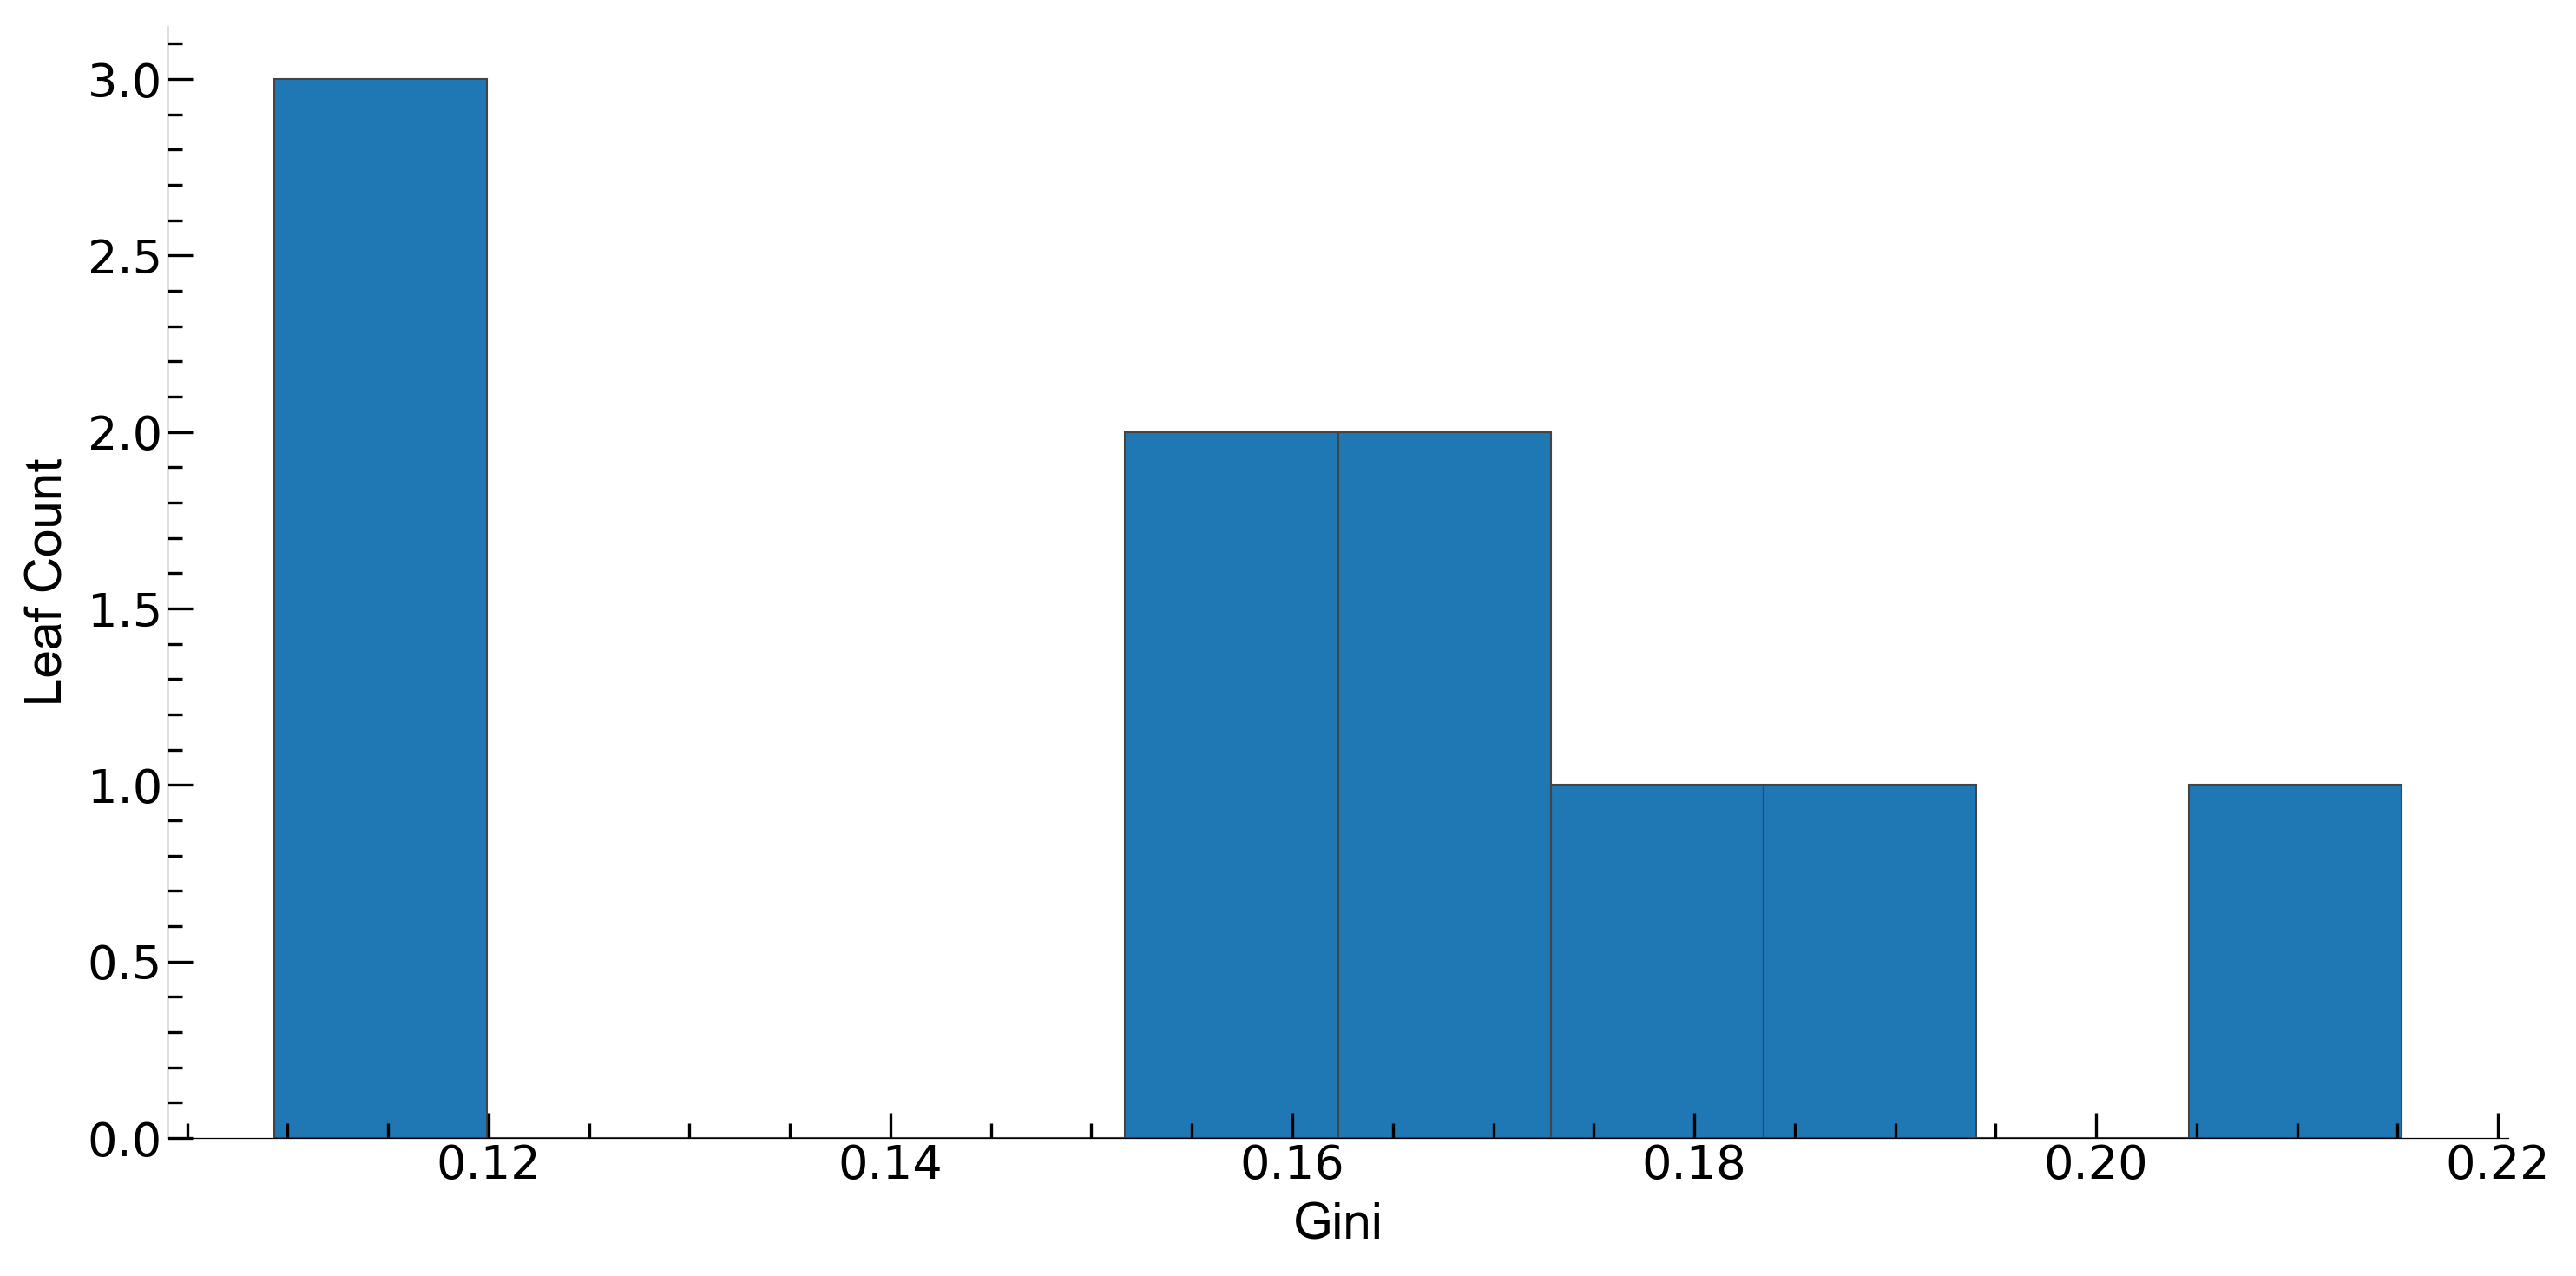

In [47]:
trees.viz_leaf_criterion(shadow_figs_0, display_type='hist', **dtv_params_gen)
save_plt(output, 'viz_leaf_criterion_hist_figs_0')

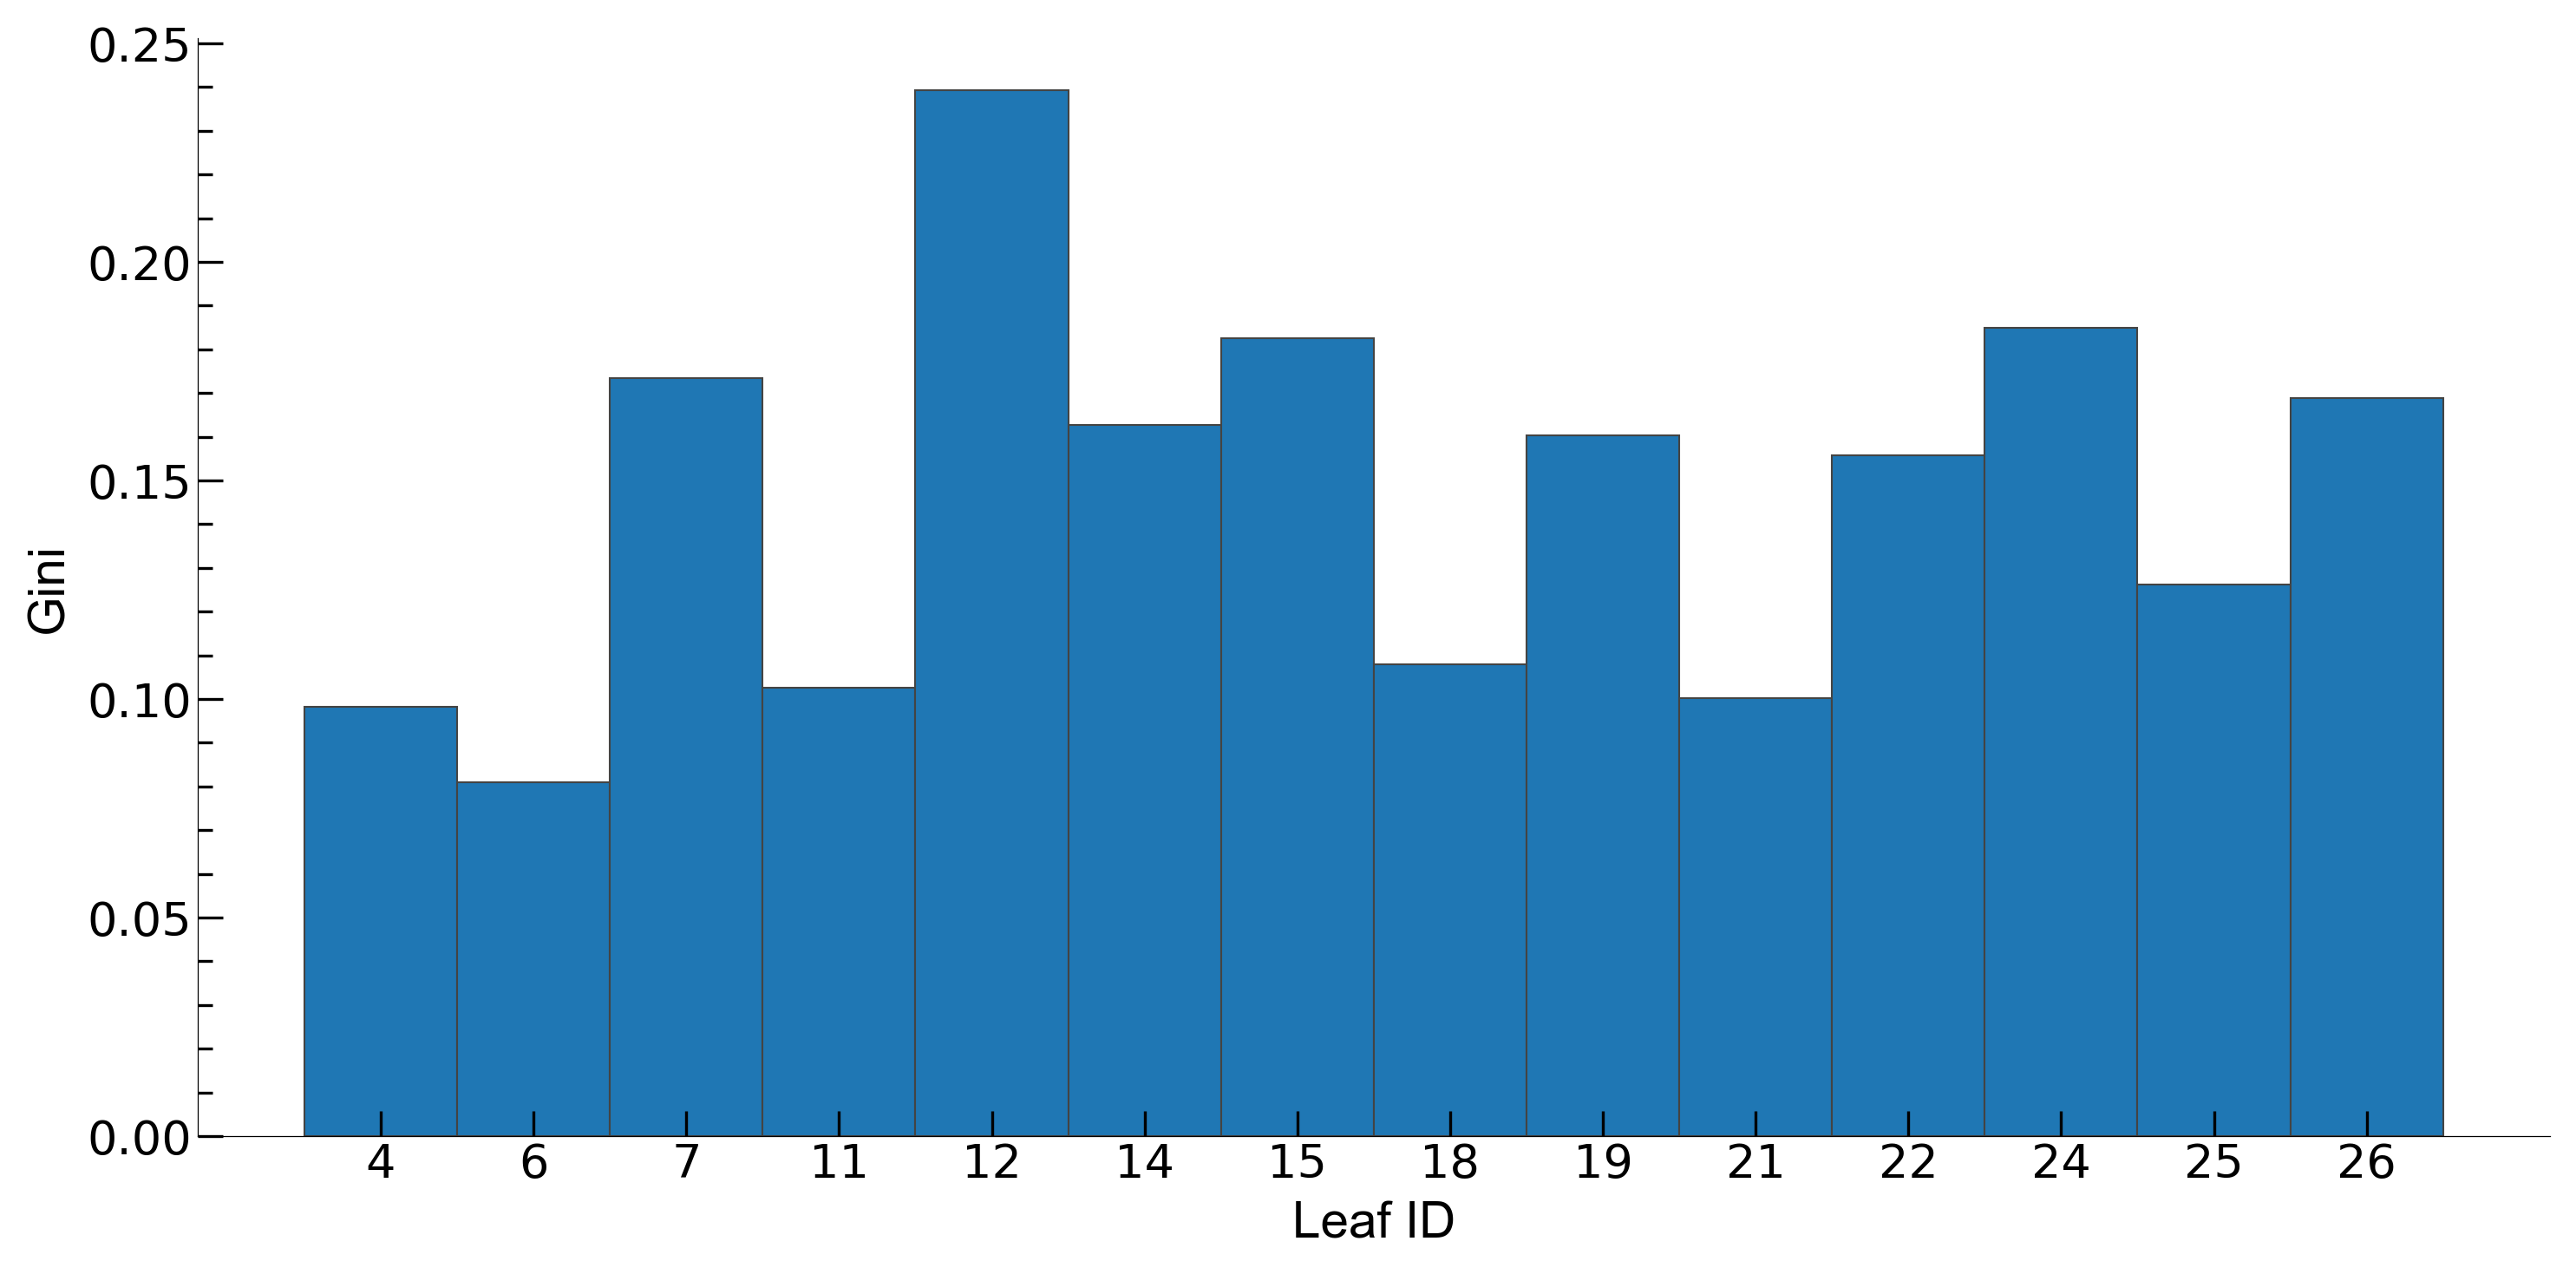

In [48]:
trees.viz_leaf_criterion(shadow_figs_1, display_type='plot', **dtv_params_gen)
save_plt(output, 'viz_leaf_criterion_figs_1')

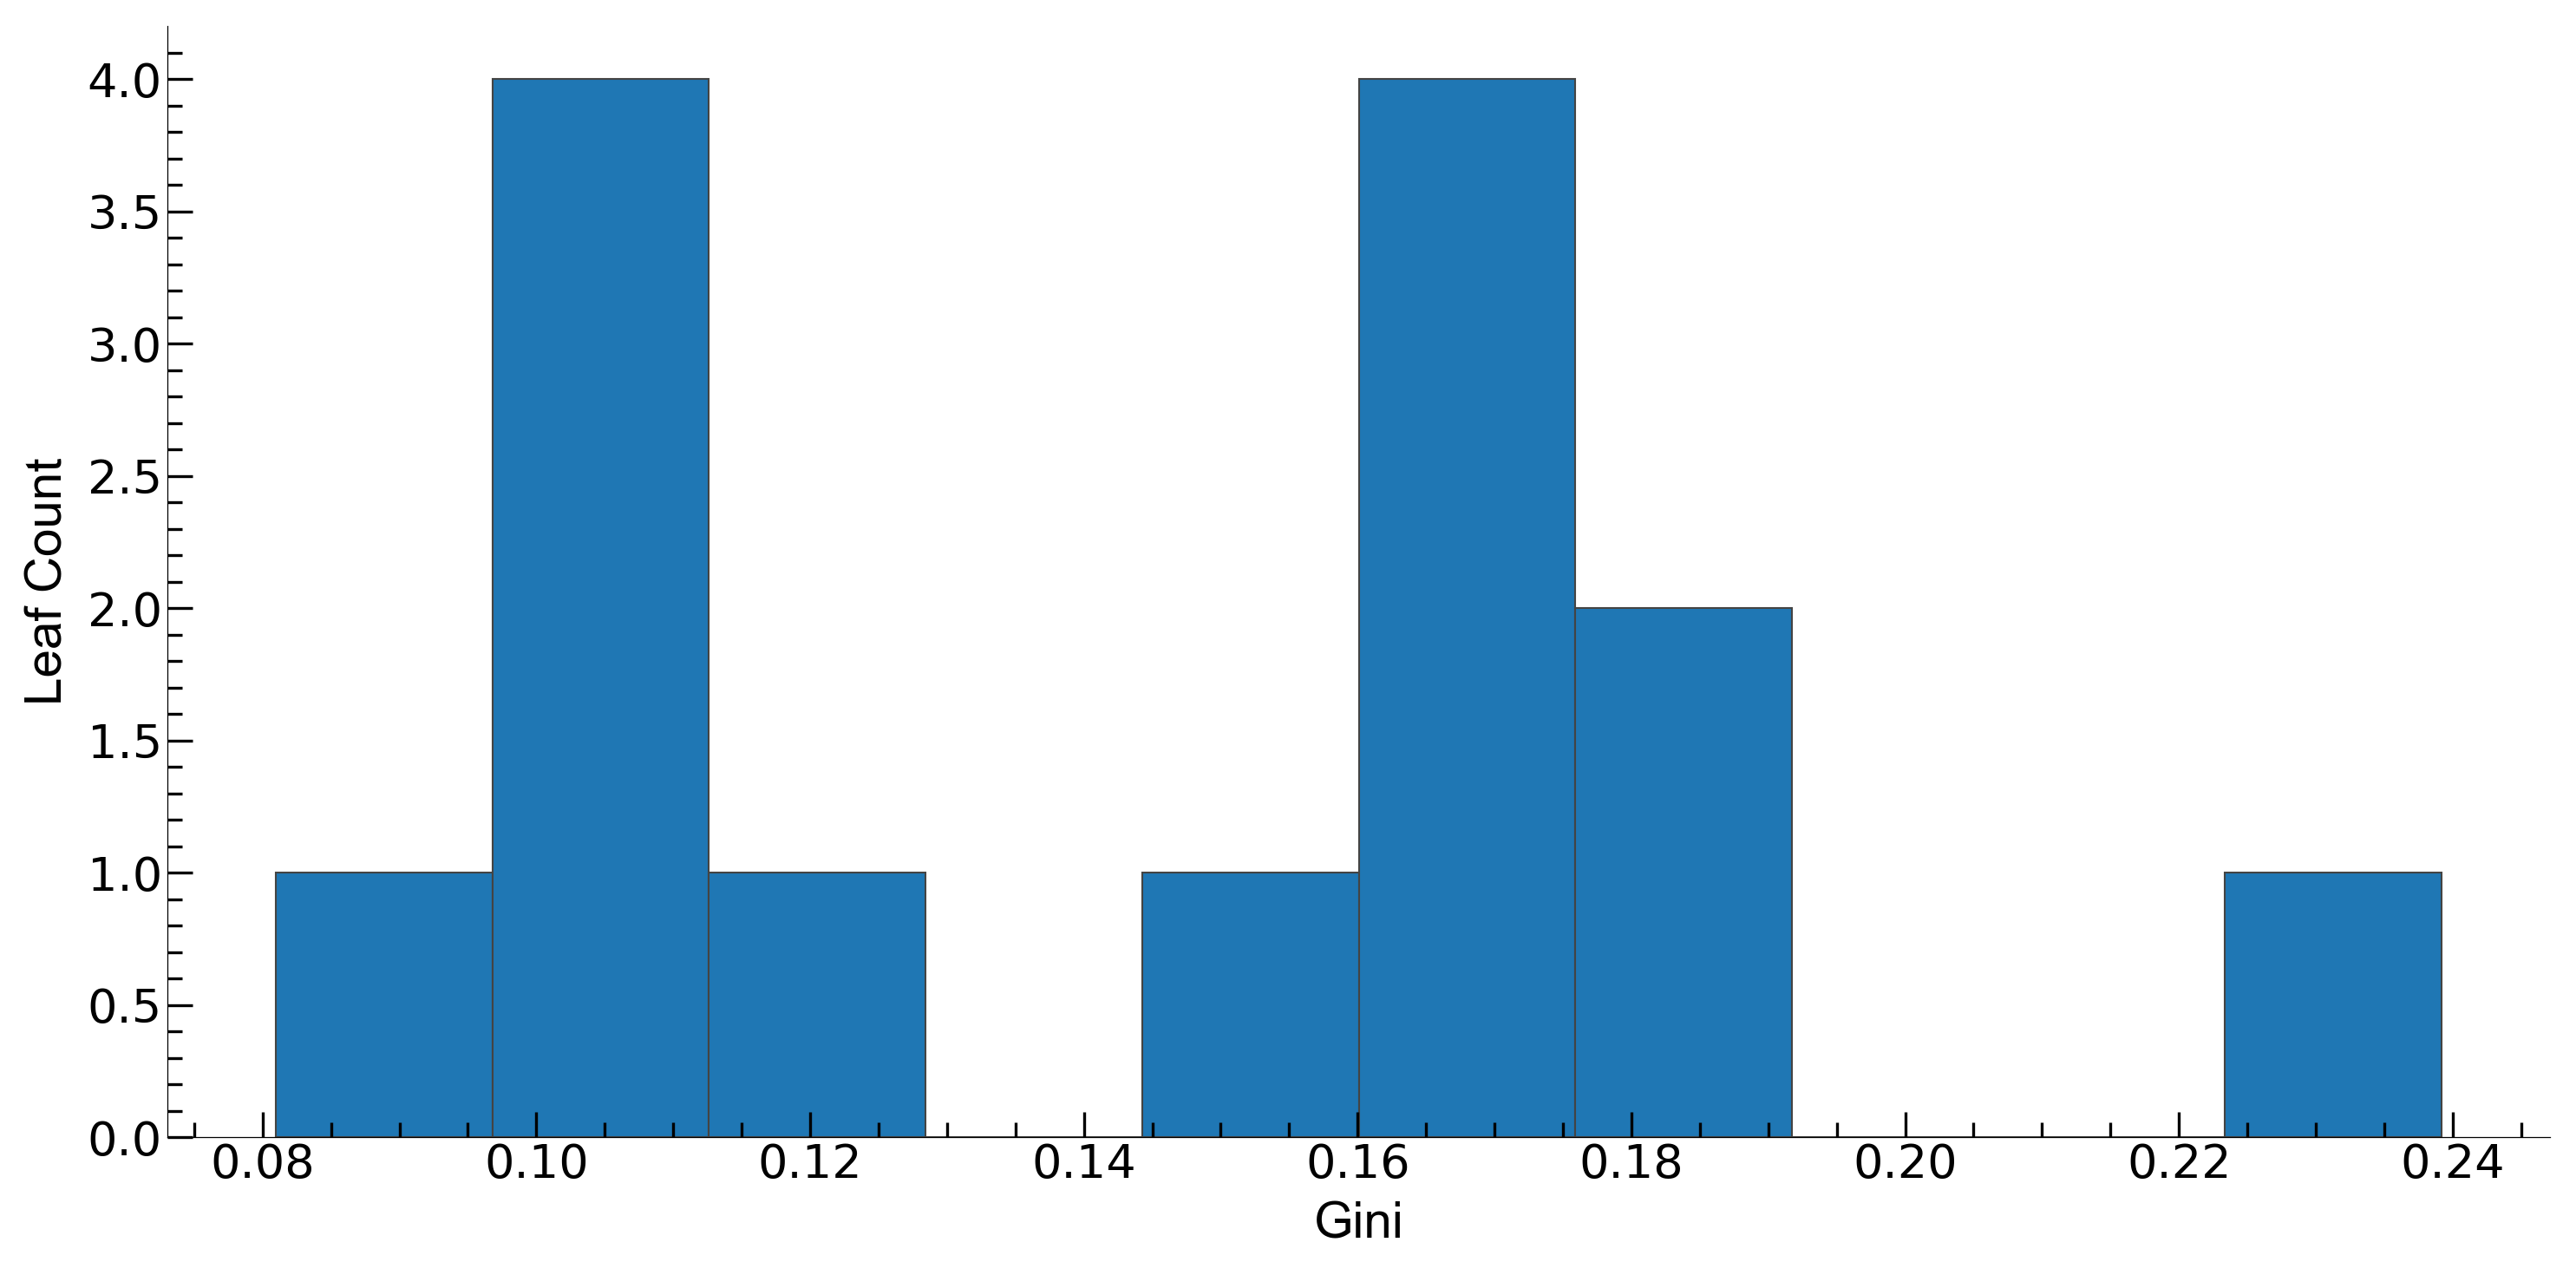

In [49]:
trees.viz_leaf_criterion(shadow_figs_1, display_type='hist', **dtv_params_gen)
save_plt(output, 'viz_leaf_criterion_hist_figs_1')

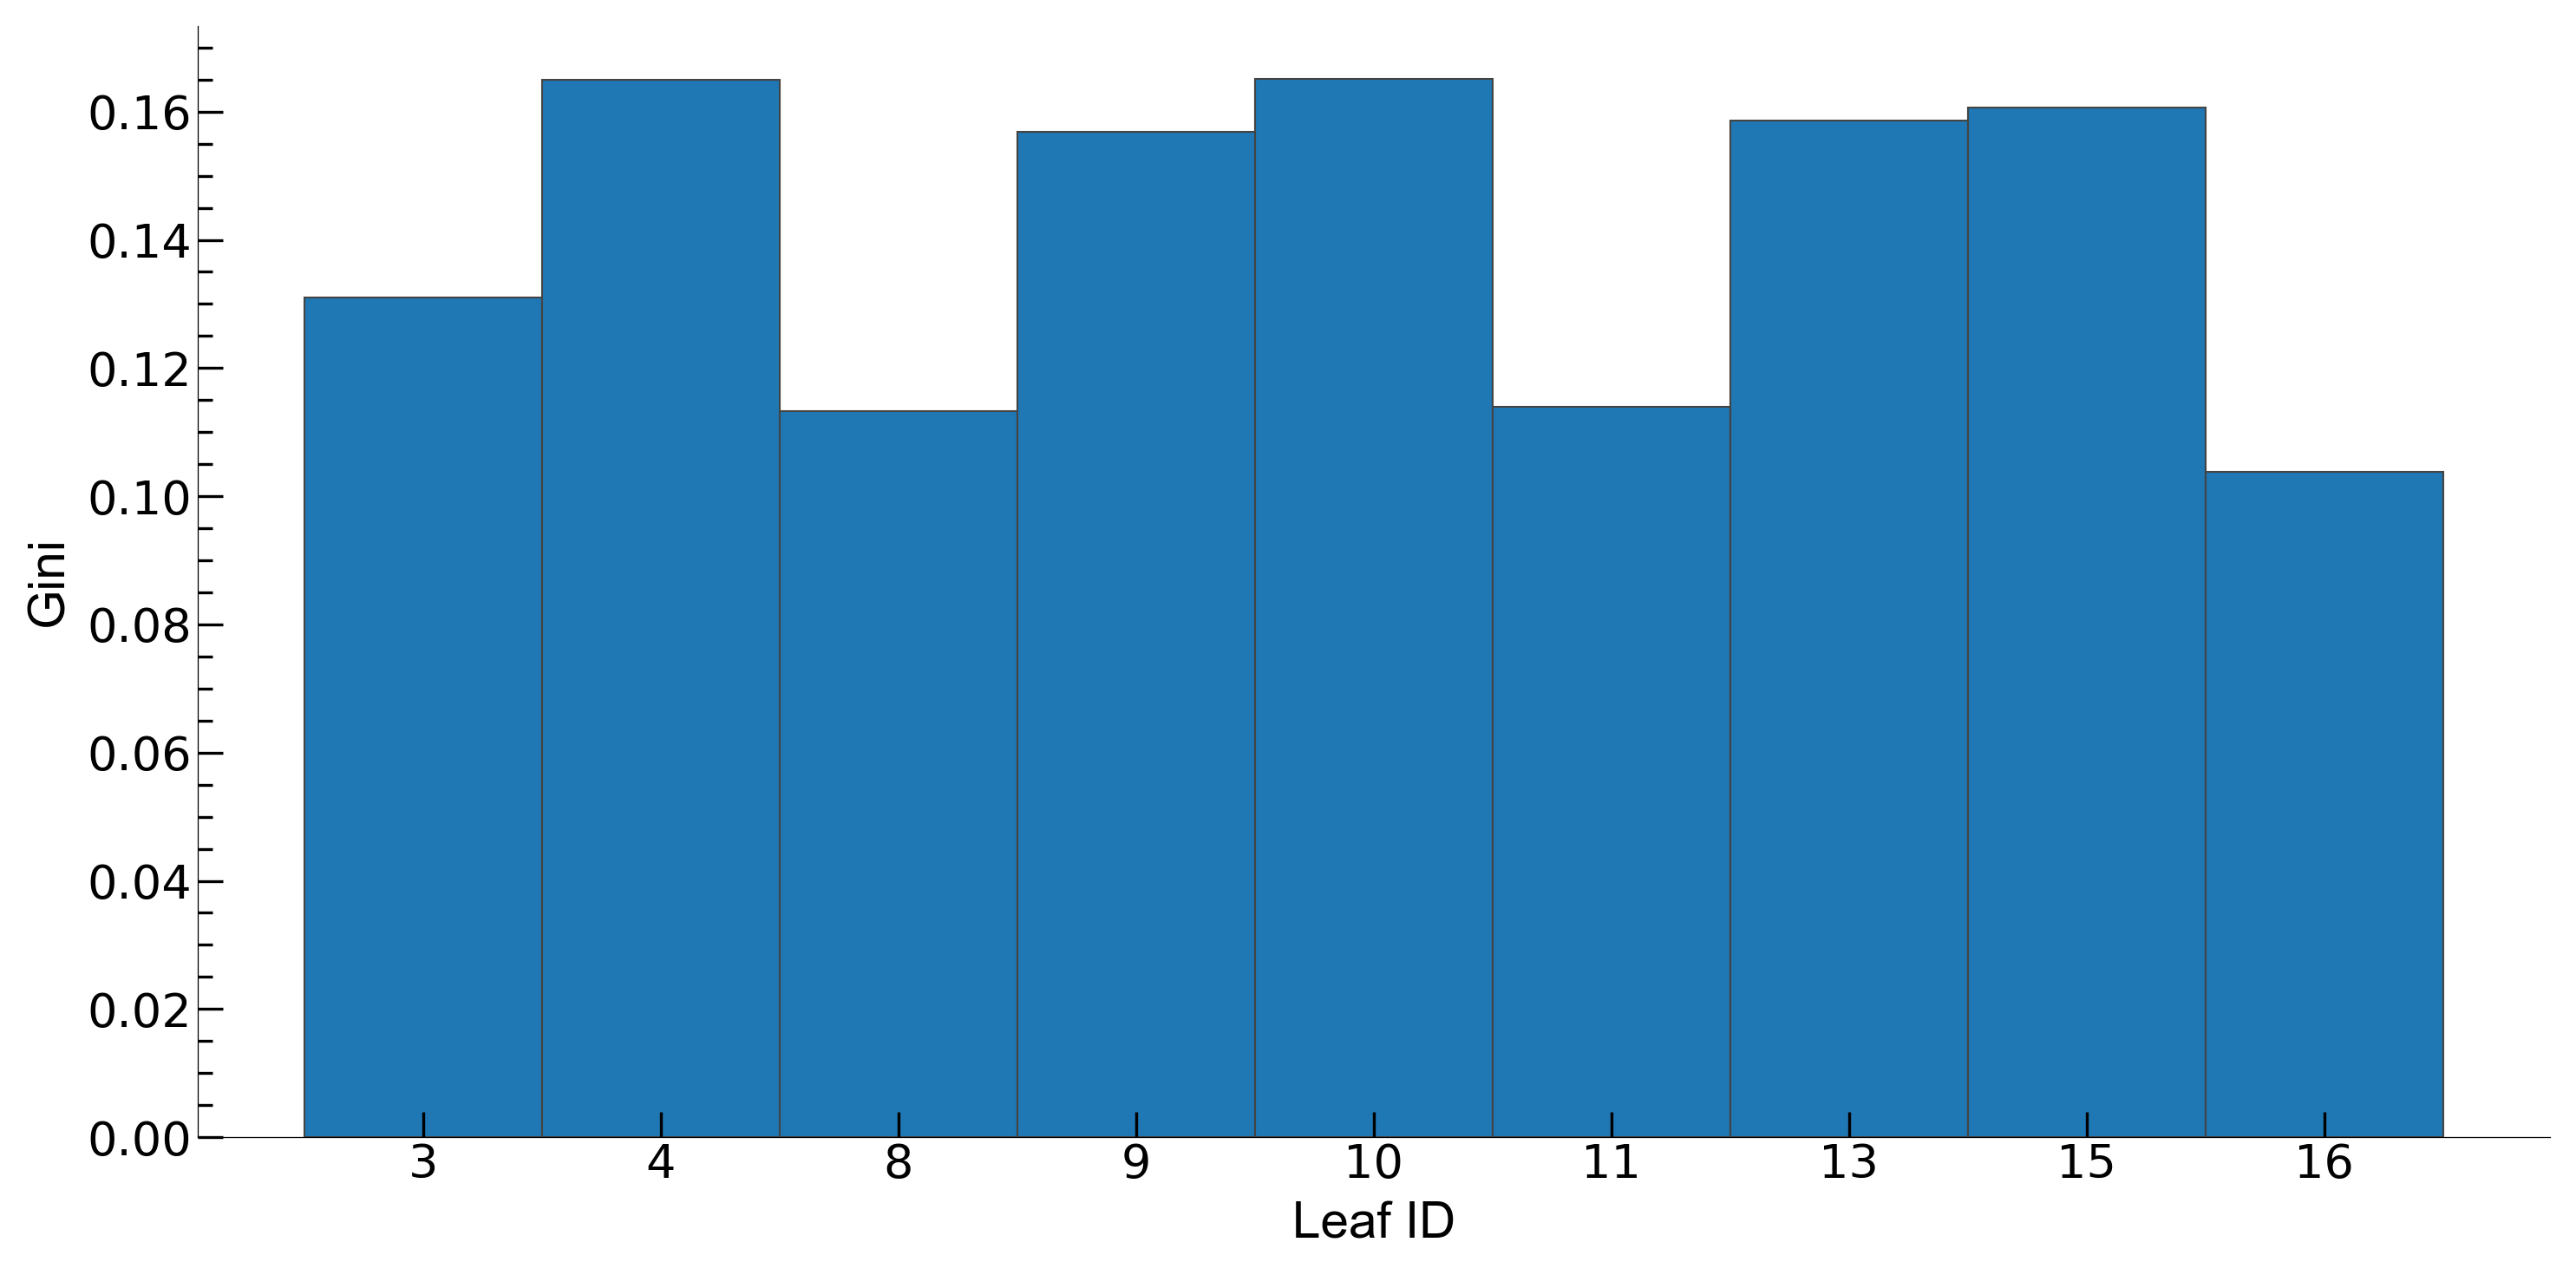

In [50]:
trees.viz_leaf_criterion(shadow_figs_2, display_type='plot', **dtv_params_gen)
save_plt(output, 'viz_leaf_criterion_figs_2')

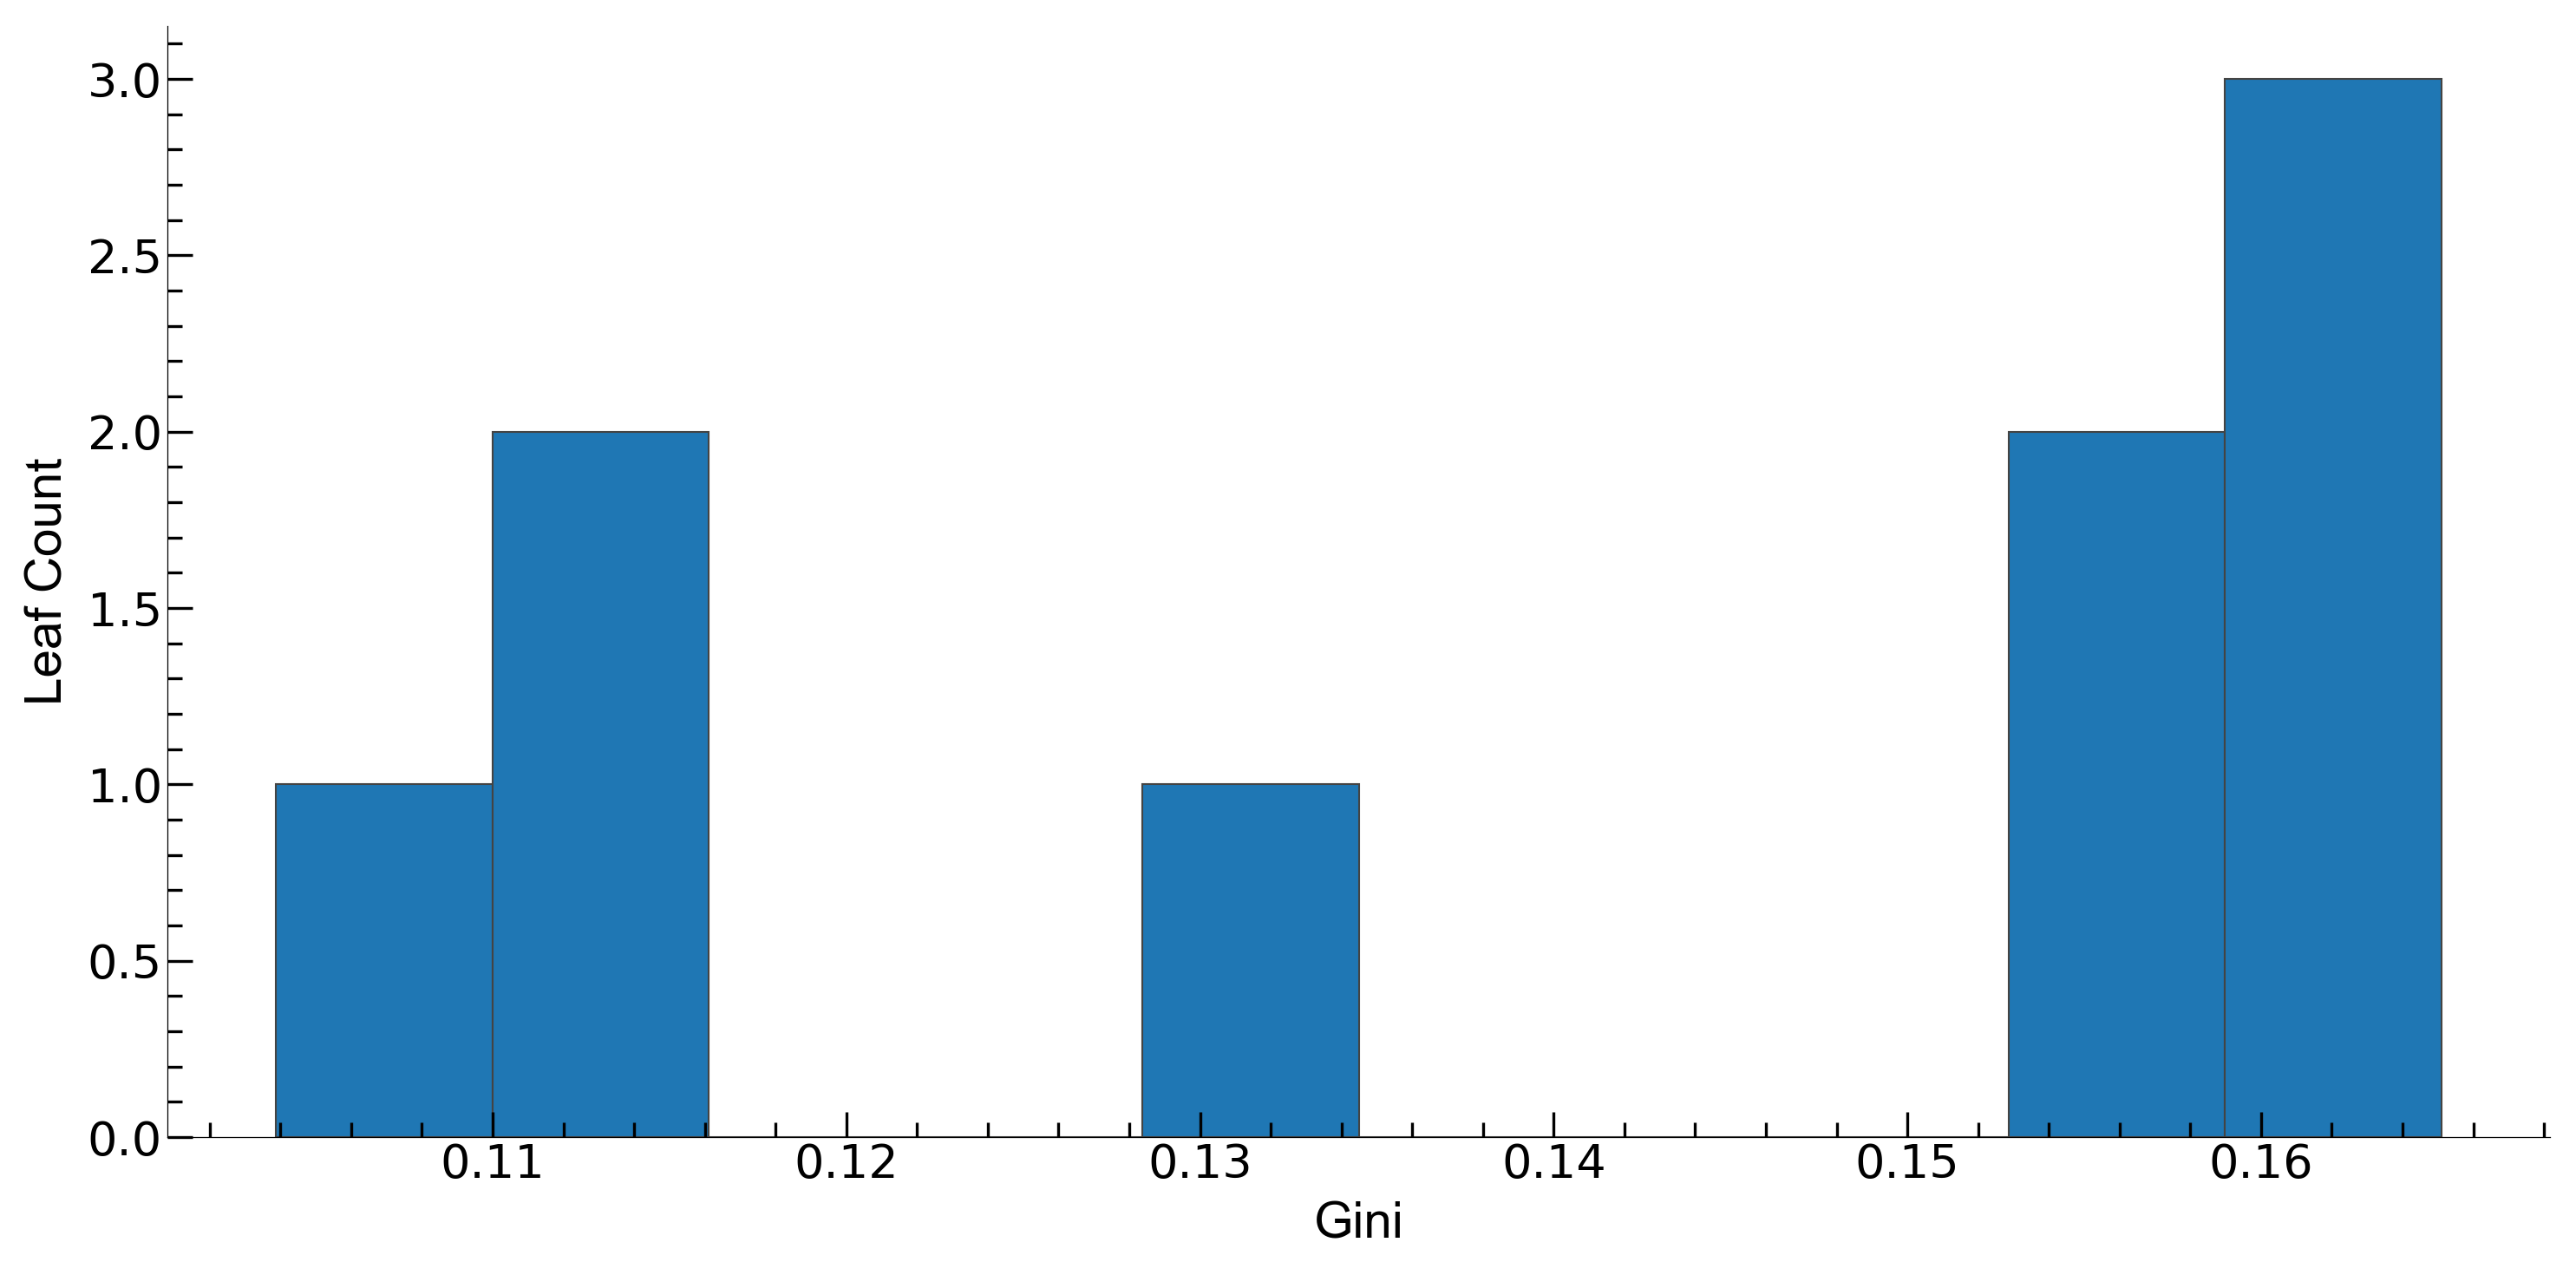

In [51]:
trees.viz_leaf_criterion(shadow_figs_2, display_type='hist', **dtv_params_gen)
save_plt(output, 'viz_leaf_criterion_hist_figs_2')

### Splits in Feature Space

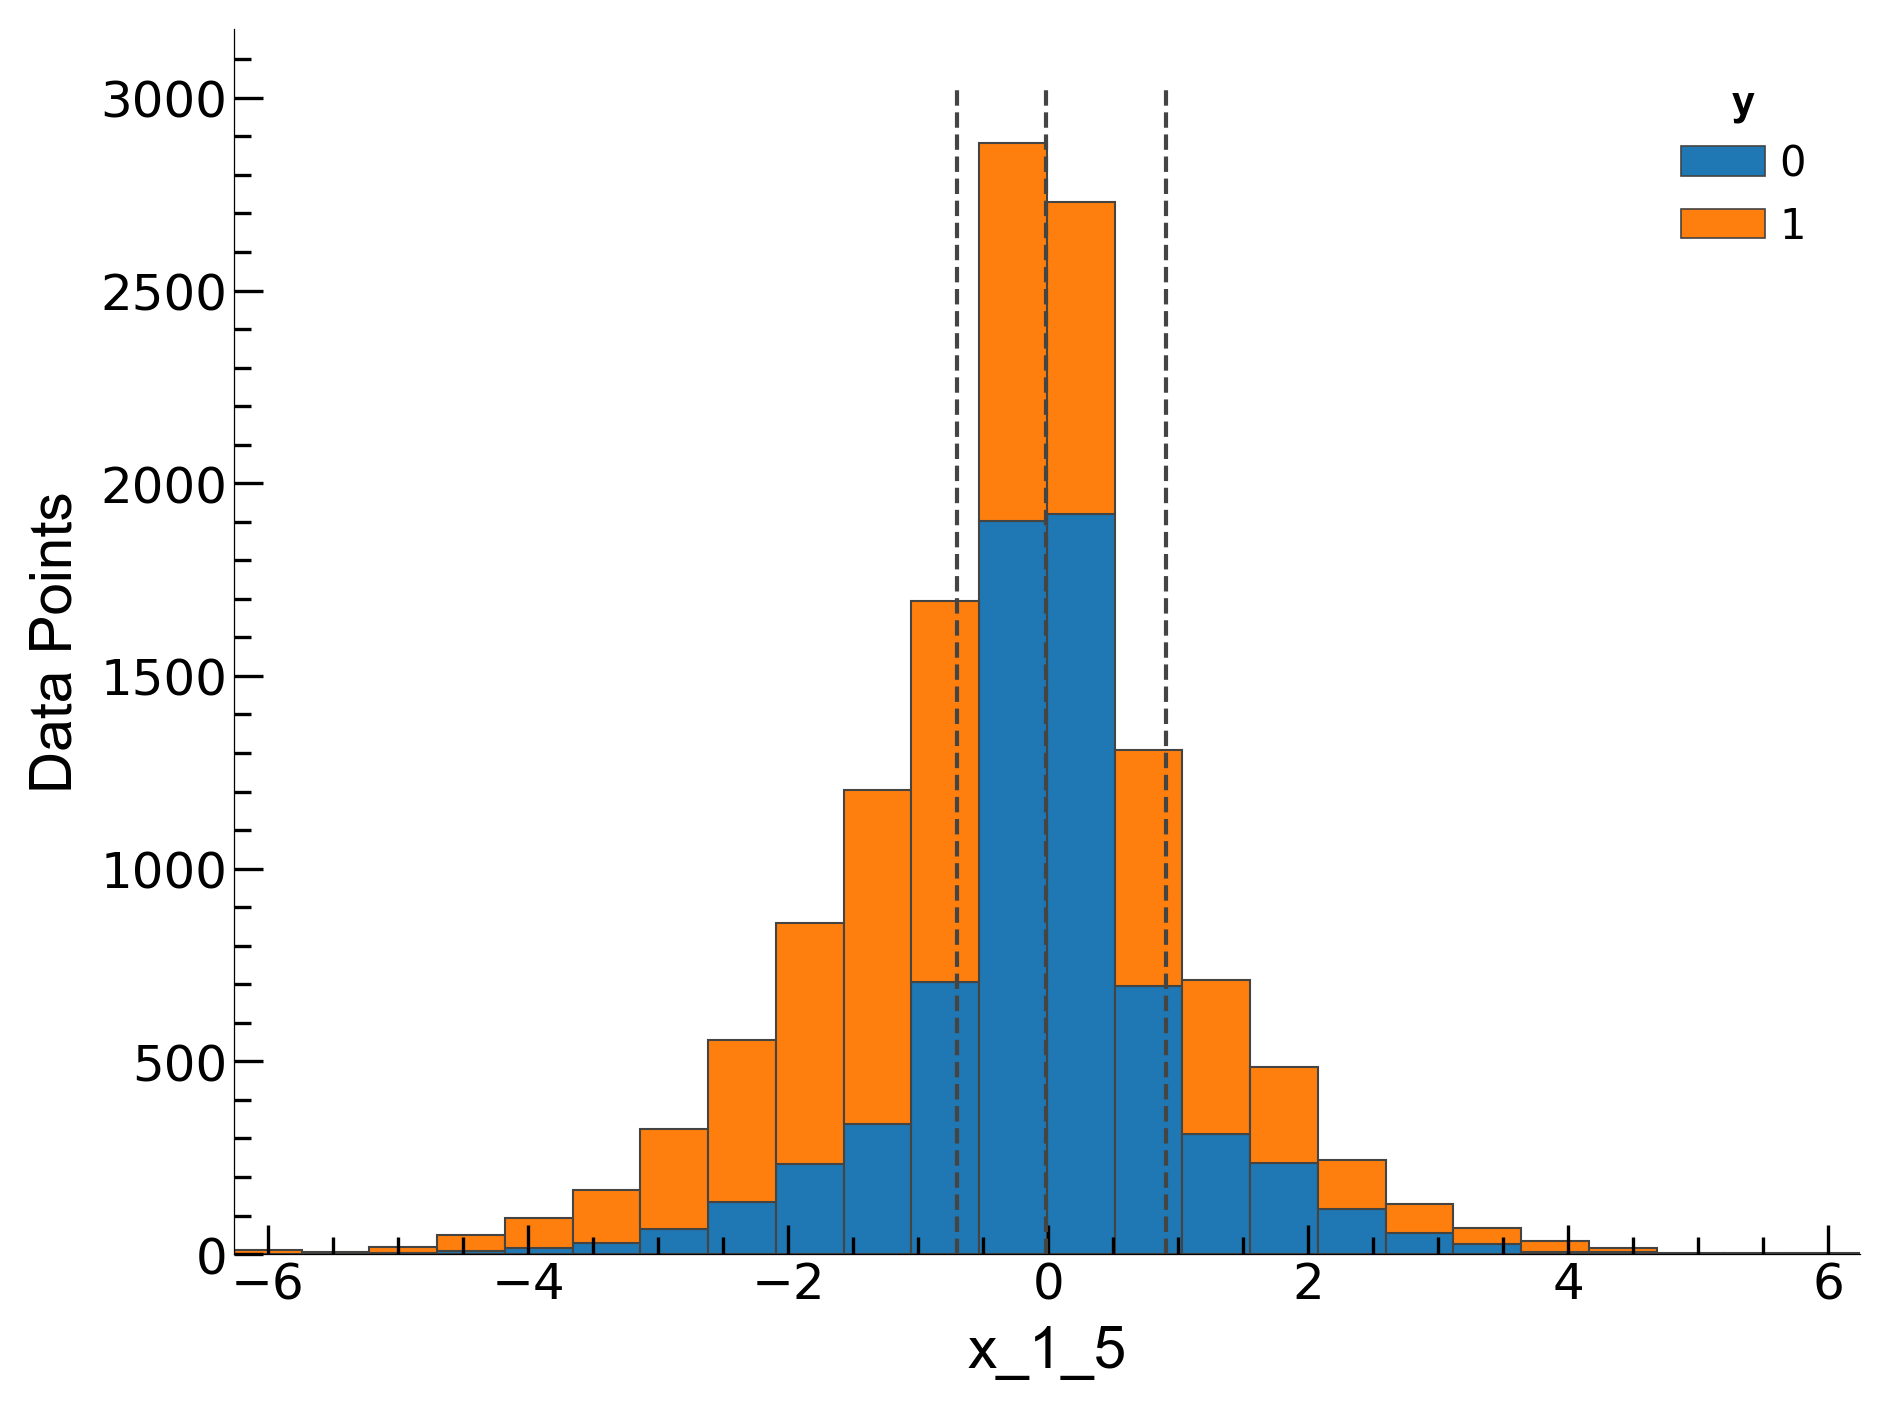

In [52]:
trees.ctreeviz_univar(shadow_figs_0, feature_name=feature_to_look_at_in_detail, **dtv_params_gen, gtype = 'barstacked', show={'legend', 'splits', 'axis'})
save_plt(output, 'ctreeviz_univar_figs_0')

### Node Sample

In [53]:
trees.describe_node_sample(shadow_figs_0, 18)

x_0_0       x_0_1       x_0_2       x_0_3       x_0_4       x_0_5  \
count  570.000000  570.000000  570.000000  570.000000  570.000000  570.000000   
mean    -0.369356    0.335639    0.217326   -0.254128    0.228466    0.275452   
std      1.634220    1.405395    2.056385    1.596222    1.791611    1.526709   
min     -6.827339   -3.868362   -5.855327   -5.743897   -5.664568   -5.220875   
25%     -1.364122   -0.643725   -1.056463   -1.395178   -1.013992   -0.737285   
50%     -0.393523    0.301950    0.120924   -0.332000    0.280263    0.217964   
75%      0.639059    1.323619    1.643107    0.873196    1.401385    1.222283   
max      5.730185    4.424786    6.240636    3.778047    6.554756    5.364136   

            x_0_6       x_0_7       x_0_8       x_0_9  ...       x_1_5  \
count  570.000000  570.000000  570.000000  570.000000  ...  570.000000   
mean    -0.160202   -0.105811    0.320374    0.255232  ...    1.979623   
std      1.862977    1.784751    1.256999    1.965779  ...    0.938258   
min     -5.025230   -5.342739   -5.473044   -5.348863  ...    0.908441   
25%     -1.454702   -1.270684   -0.393778   -1.083809  ...    1.215586   
50%     -0.118781   -0.152053    0.350755    0.299891  ...    1.749608   
75%      1.135414    1.047969    1.063432    1.707483  ...    2.511303   
max      5.453392    5.168874    5.630788    5.193942  ...    6.242412   

            x_1_6       x_1_7       x_1_8       x_1_9      x_1_10      x_1_11  \
count  570.000000  570.000000  570.000000  570.000000  570.000000  570.000000   
mean     2.062430   -0.044281    0.069286   -0.019219    0.004694   -0.004934   
std      0.790401    0.973217    0.999401    1.049653    0.959909    0.977210   
min      1.081239   -3.109847   -3.439977   -3.253034   -2.750652   -2.587219   
25%      1.430078   -0.702679   -0.598585   -0.732600   -0.711858   -0.651529   
50%      1.867427   -0.000388    0.011357   -0.042317    0.001265    0.022078   
75%      2.531968    0.632779    0.768401    0.659574    0.682061    0.643527   
max      4.849715    3.070933    3.664263    3.453528    3.001458    2.591537   

           x_1_12      x_1_13      x_1_14  
count  570.000000  570.000000  570.000000  
mean    -0.034697    0.002119    0.018557  
std      0.997170    1.003238    0.973759  
min     -3.566403   -2.935721   -2.931006  
25%     -0.651364   -0.689749   -0.660767  
50%     -0.064023   -0.054899   -0.020457  
75%      0.636301    0.630981    0.626899  
max      2.990413    3.022757    3.063999  

[8 rows x 30 columns]

## XGBoost
Tree 0 only

In [54]:
shadow_xgboost_0 = ShadowXGBDTree(model_xgboost, 0, X_train, y_train, feat_names, 'y', [0, 1])

### Trees

#### Split Hists

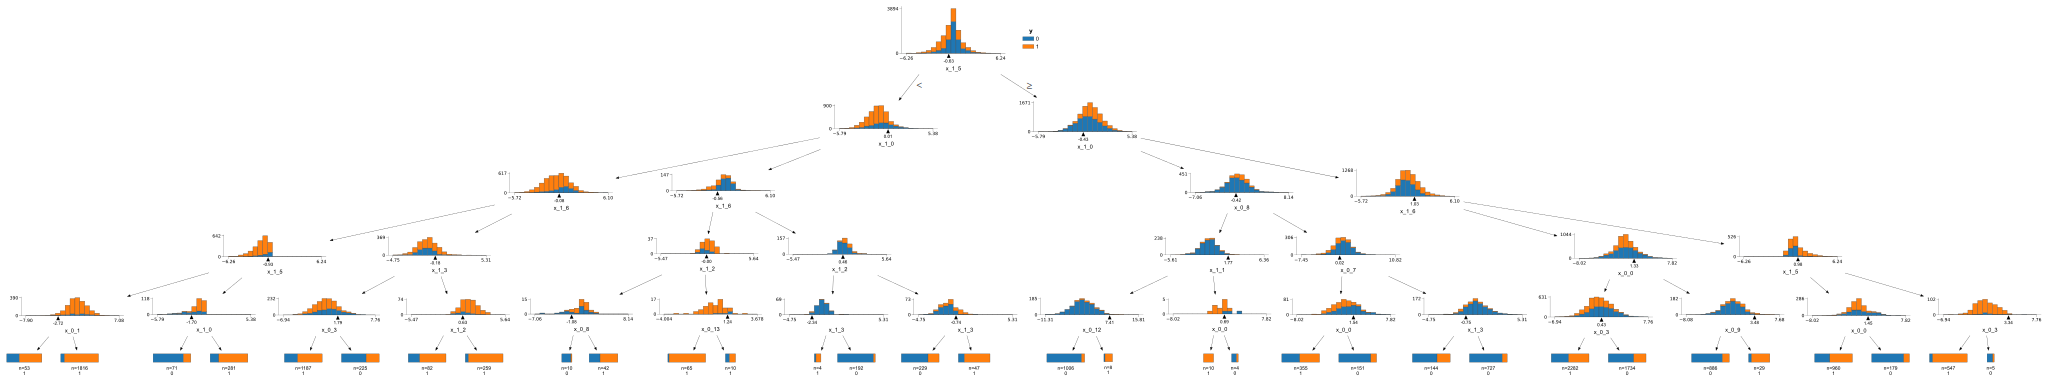

In [55]:
viz = trees.dtreeviz(shadow_xgboost_0, **dtv_params)
save_dtreeviz(viz, output, 'dtreeviz_xgboost_0')

#### Text

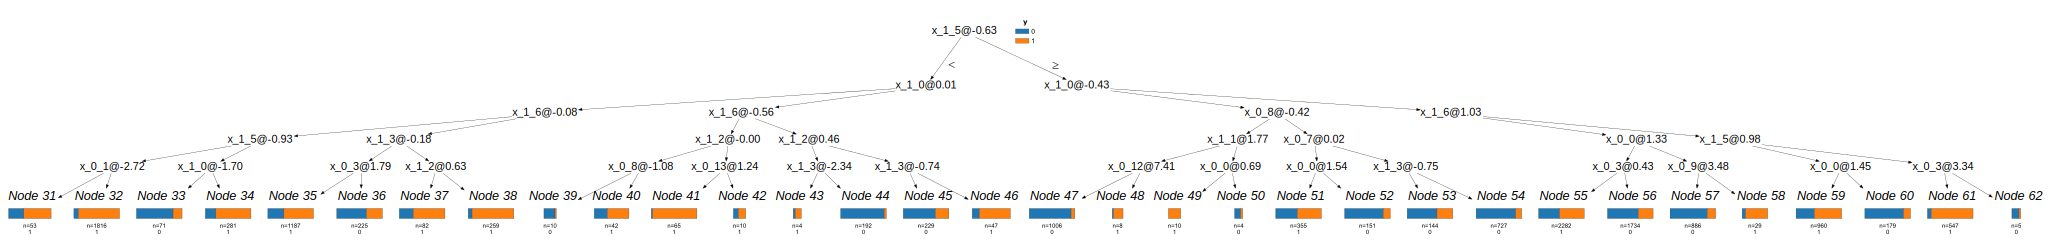

In [56]:
viz = trees.dtreeviz(shadow_xgboost_0, **dtv_params, fancy=False, show_node_labels=True)
save_dtreeviz(viz, output, 'dtreeviz_text_xgboost_0')

### Prediction Path

In [57]:
print(trees.explain_prediction_path(shadow_xgboost_0, x=x_example, explanation_type='plain_english'))

x_0_0 < 1.33
x_0_3 < 0.43
-0.43 <= x_1_0 
-0.63 <= x_1_5 
x_1_6 < 1.03



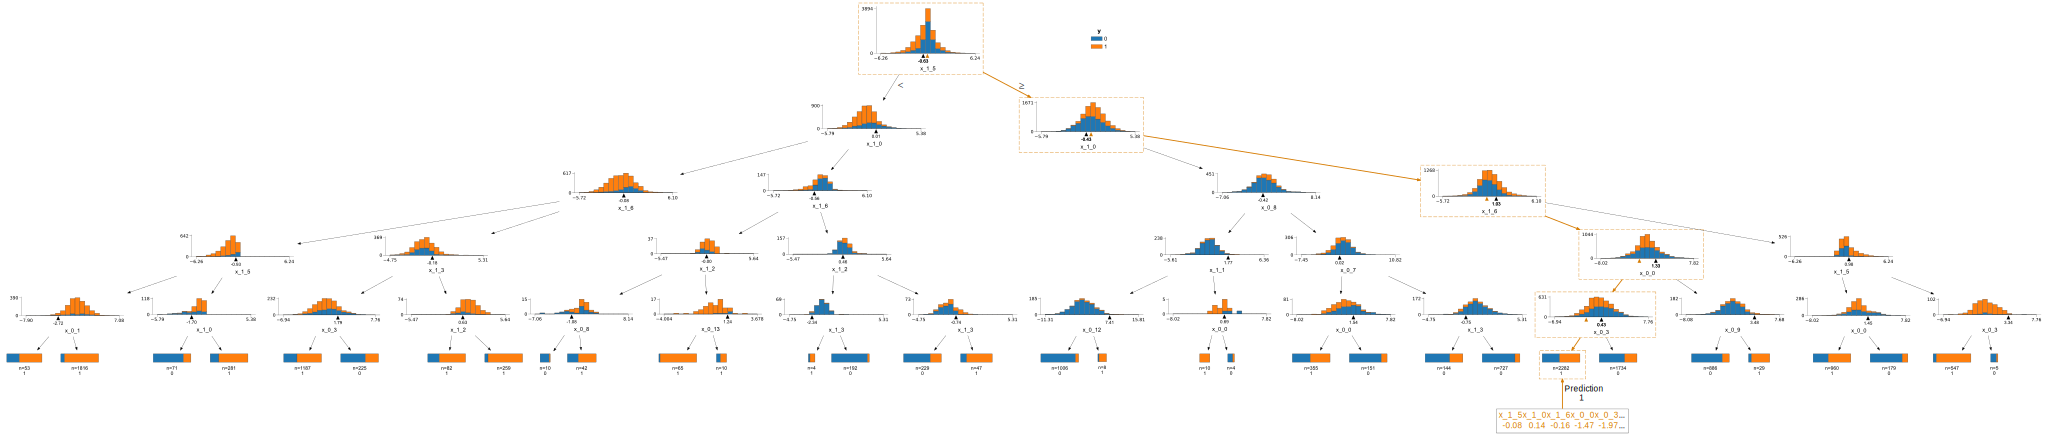

In [58]:
viz = trees.dtreeviz(shadow_xgboost_0, **dtv_params, X=x_example)
save_dtreeviz(viz, output, 'dtreeviz_pred_path_xgboost_0')

### Leaf Samples

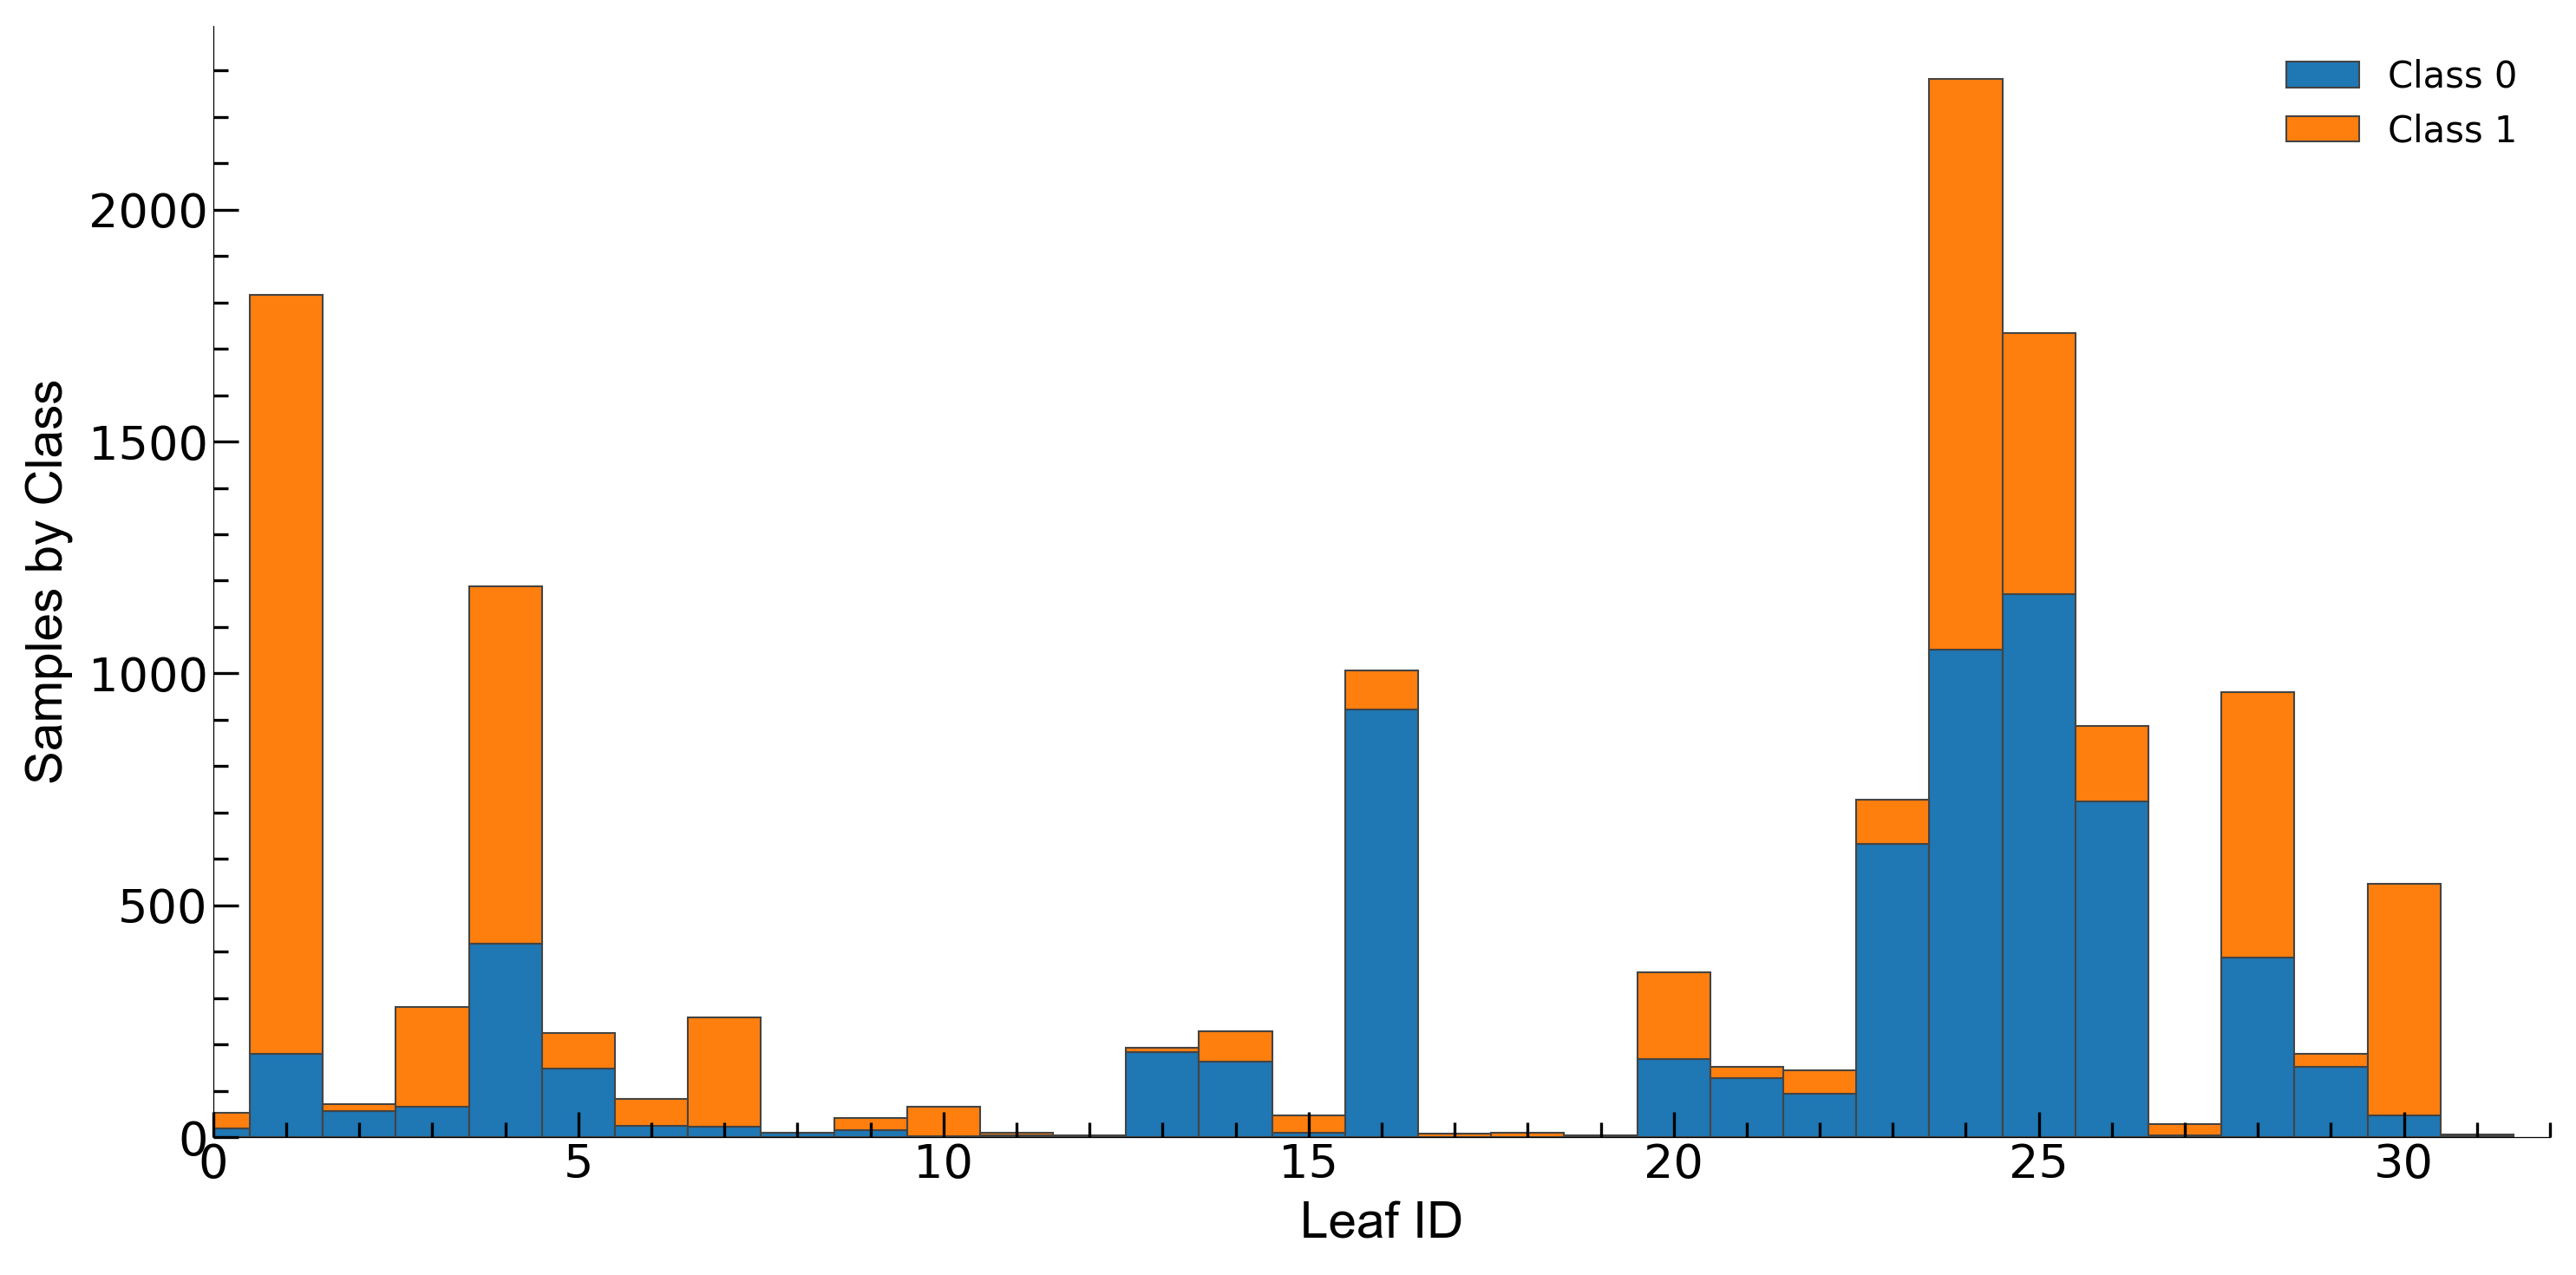

In [59]:
trees.ctreeviz_leaf_samples(shadow_xgboost_0, **dtv_params_gen, label_all_leafs=False)
save_plt(output, 'ctreeviz_leaf_samples_xgboost_0')

Leaf Criterion is not supported for `XGBoost`

### Splits in Feature Space

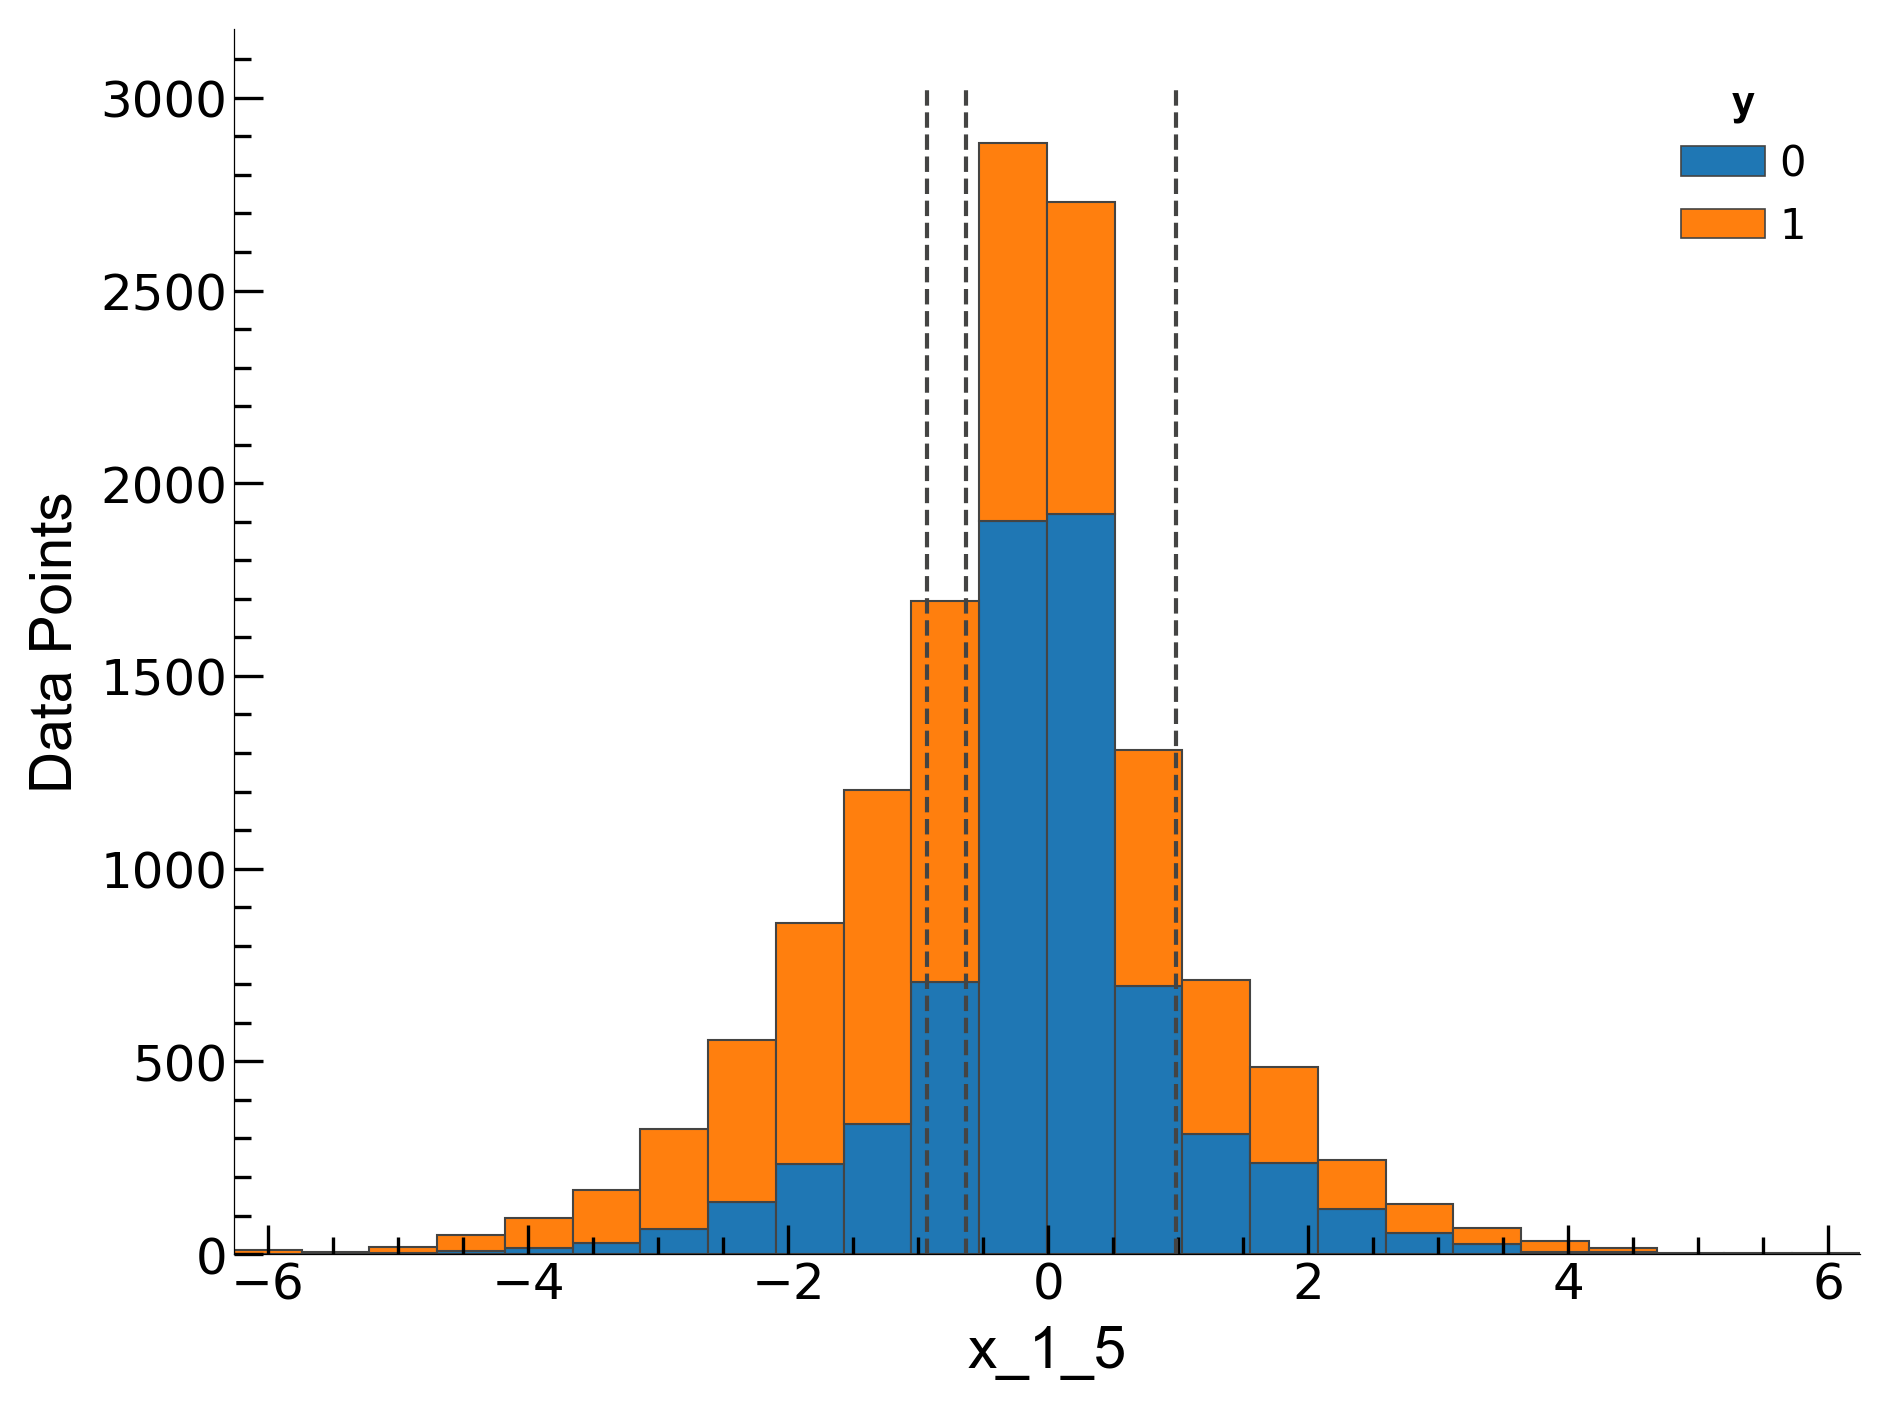

In [60]:
trees.ctreeviz_univar(shadow_xgboost_0, feature_name=feature_to_look_at_in_detail, **dtv_params_gen, gtype = 'barstacked', show={'legend', 'splits', 'axis'})
save_plt(output, 'ctreeviz_univar_xgboost_0')

### Node Sample

In [61]:
trees.describe_node_sample(shadow_xgboost_0, 42)

x_0_0      x_0_1      x_0_2      x_0_3      x_0_4      x_0_5  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean   -0.330346   0.864262   0.051781  -1.085106  -0.971066   0.365220   
std     0.995198   1.980874   1.690810   2.243211   1.545731   1.739165   
min    -2.239114  -1.300741  -3.532499  -4.196194  -3.605717  -2.791488   
25%    -0.771890  -0.600711  -0.778048  -1.825127  -1.849657  -0.848009   
50%    -0.412457   0.863744   0.468597  -1.684180  -0.715308   0.405324   
75%     0.000051   0.974459   0.747401  -0.100182   0.052867   1.936913   
max     1.191651   5.343402   2.910201   3.853144   1.376898   2.241964   

           x_0_6      x_0_7      x_0_8      x_0_9  ...      x_1_5      x_1_6  \
count  10.000000  10.000000  10.000000  10.000000  ...  10.000000  10.000000   
mean   -0.056747  -0.021866   0.209227   0.322105  ...  -1.338274  -1.653011   
std     1.744425   1.667385   1.124264   2.015149  ...   0.387490   0.566087   
min    -1.823981  -2.372353  -1.133350  -2.313379  ...  -2.009087  -2.475372   
25%    -1.599534  -1.006022  -0.530742  -0.599658  ...  -1.603145  -2.129895   
50%    -0.570676   0.013759  -0.111589  -0.003224  ...  -1.345180  -1.593287   
75%     1.429790   0.416868   1.011372   0.744128  ...  -1.122846  -1.300025   
max     3.052865   3.086583   2.365511   4.313421  ...  -0.753151  -0.799854   

           x_1_7      x_1_8      x_1_9     x_1_10     x_1_11     x_1_12  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.228753   0.171253   0.074028  -0.031538  -0.244435  -0.226181   
std     1.035866   0.663637   0.574839   1.197964   1.456320   0.918399   
min    -1.012202  -1.073054  -0.952160  -1.622586  -1.974549  -1.436925   
25%    -0.648126  -0.187724  -0.149040  -0.916234  -1.153537  -0.949985   
50%     0.139845   0.206221  -0.066533  -0.212395  -0.565584  -0.183623   
75%     0.910998   0.773237   0.529036   1.014965   0.111061   0.504837   
max     1.762062   0.943733   0.866785   1.770274   3.303661   1.098917   

          x_1_13     x_1_14  
count  10.000000  10.000000  
mean    0.083307   0.040694  
std     0.899355   1.113500  
min    -1.323272  -2.157436  
25%    -0.535549  -0.558273  
50%    -0.012099  -0.011620  
75%     0.852996   0.710665  
max     1.367439   1.765827  

[8 rows x 30 columns]

***
# Tree Functions

## FIGS

In [62]:
expr_figs_0 = skompile(dt_figs_0.predict_proba, feat_names)

In [63]:
print(expr_figs_0.to('sqlalchemy/sqlite', component=1, assign_to='tree_0'))

SELECT CASE WHEN (x_1_5 <= -0.7042788565158844) THEN CASE WHEN (x_1_0 <= 0.06704867258667946) THEN CASE WHEN (x_1_6 <= -0.31406813859939575) THEN 0.8797702092736972 ELSE CASE WHEN (x_0_10 <= -0.04627775028347969) THEN 0.7567567567567568 ELSE 0.6050670640834576 END END ELSE CASE WHEN (x_1_6 <= -0.20230819284915924) THEN 0.628140703517588 ELSE 0.1789709172259508 END END ELSE CASE WHEN (x_1_0 <= -0.46404866874217987) THEN 0.19776609724047306 ELSE CASE WHEN (x_1_6 <= 1.081115484237671) THEN 0.40476190476190477 ELSE CASE WHEN (x_1_5 <= 0.9069100916385651) THEN CASE WHEN (x_1_5 <= -0.019519444555044174) THEN 0.7429906542056075 ELSE 0.4444444444444444 END ELSE 0.8914616497829233 END END END END AS tree_0 
FROM data


In [64]:
print(expr_figs_0.to('python/code'))

(((np.array([0.12022979072630283, 0.8797702092736972]) if x_1_6 <= 
    -0.31406813859939575 else np.array([0.24324324324324326, 
    0.7567567567567568]) if x_0_10 <= -0.04627775028347969 else np.
    array([0.3949329359165425, 0.6050670640834576])) if x_1_0 <= 
    0.06704867258667946 else np.array([0.37185929648241206, 
    0.628140703517588]) if x_1_6 <= -0.20230819284915924 else np.array(
    [0.8210290827740492, 0.1789709172259508])) if x_1_5 <= 
    -0.7042788565158844 else np.array([0.8022339027595269, 
    0.19776609724047306]) if x_1_0 <= -0.46404866874217987 else np.
    array([0.5952380952380952, 0.40476190476190477]) if x_1_6 <= 
    1.081115484237671 else (np.array([0.2570093457943925, 
    0.7429906542056075]) if x_1_5 <= -0.019519444555044174 else np.
    array([0.5555555555555556, 0.4444444444444444])) if x_1_5 <= 
    0.9069100916385651 else np.array([0.1085383502170767, 
    0.8914616497829233]))



In [65]:
expr_figs_1 = skompile(dt_figs_1.predict_proba, feat_names)

In [66]:
print(expr_figs_1.to('sqlalchemy/sqlite', component=1, assign_to='tree_1'))

SELECT CASE WHEN (x_0_0 <= 1.318644642829895) THEN CASE WHEN (x_0_3 <= 1.0022135376930237) THEN CASE WHEN (x_0_8 <= -1.3993919491767883) THEN CASE WHEN (x_0_5 <= -0.9654896557331085) THEN 0.12236286919831224 ELSE CASE WHEN (x_0_2 <= -0.9088979661464691) THEN 0.1871508379888268 ELSE 0.5576923076923077 END END ELSE CASE WHEN (x_0_2 <= 0.32256796956062317) THEN CASE WHEN (x_0_6 <= -1.244779348373413) THEN CASE WHEN (x_0_2 <= -0.8020171821117401) THEN 0.12219959266802444 ELSE 0.564625850340136 END ELSE CASE WHEN (x_0_0 <= -2.2443041801452637) THEN 0.28865979381443296 ELSE 0.6776737309019222 END END ELSE CASE WHEN (x_0_6 <= 1.4416866898536682) THEN CASE WHEN (x_1_5 <= -0.7239388227462769) THEN 0.8907996560619088 ELSE 0.8042296072507553 END ELSE CASE WHEN (x_0_5 <= 0.24936344474554062) THEN 0.16666666666666666 ELSE 0.7321428571428571 END END END END ELSE CASE WHEN (x_0_3 <= 2.8803837299346924) THEN 0.43819875776397516 ELSE 0.20943952802359883 END END ELSE 0.2695563833389773 END AS tree_1 
FR

In [67]:
print(expr_figs_1.to('python/code'))

((((np.array([0.8776371308016878, 0.12236286919831224]) if x_0_5 <= 
    -0.9654896557331085 else np.array([0.8128491620111732, 
    0.1871508379888268]) if x_0_2 <= -0.9088979661464691 else np.array(
    [0.4423076923076923, 0.5576923076923077])) if x_0_8 <= 
    -1.3993919491767883 else ((np.array([0.8778004073319755, 
    0.12219959266802444]) if x_0_2 <= -0.8020171821117401 else np.array
    ([0.43537414965986393, 0.564625850340136])) if x_0_6 <= 
    -1.244779348373413 else np.array([0.711340206185567, 
    0.28865979381443296]) if x_0_0 <= -2.2443041801452637 else np.array
    ([0.3223262690980779, 0.6776737309019222])) if x_0_2 <= 
    0.32256796956062317 else (np.array([0.10920034393809114, 
    0.8907996560619088]) if x_1_5 <= -0.7239388227462769 else np.array(
    [0.1957703927492447, 0.8042296072507553])) if x_0_6 <= 
    1.4416866898536682 else np.array([0.8333333333333334, 
    0.16666666666666666]) if x_0_5 <= 0.24936344474554062 else np.array
    ([0.26785714285714285, 0

In [68]:
expr_figs_2 = skompile(dt_figs_2.predict_proba, feat_names)

In [69]:
print(expr_figs_2.to('sqlalchemy/sqlite', component=1, assign_to='tree_2'))

SELECT CASE WHEN (x_0_9 <= 1.7099669575691223) THEN CASE WHEN (x_0_8 <= -0.1480320617556572) THEN CASE WHEN (x_0_9 <= -0.28169122338294983) THEN 0.2814814814814815 ELSE 0.43988963342530546 END ELSE CASE WHEN (x_0_5 <= 1.9899896383285522) THEN CASE WHEN (x_0_6 <= -1.2163918018341064) THEN CASE WHEN (x_0_2 <= -1.3544537425041199) THEN 0.13785557986870897 ELSE 0.7973262032085562 END ELSE 0.5355944179473591 END ELSE 0.2824242424242424 END END ELSE CASE WHEN (x_0_1 <= -0.840586245059967) THEN 0.32432432432432434 ELSE CASE WHEN (x_0_8 <= 2.454321265220642) THEN 0.7838266384778013 ELSE 0.19387755102040816 END END END AS tree_2 
FROM data


In [70]:
print(expr_figs_2.to('python/code'))

(((np.array([0.7185185185185186, 0.2814814814814815]) if x_0_9 <= 
    -0.28169122338294983 else np.array([0.5601103665746945, 
    0.43988963342530546])) if x_0_8 <= -0.1480320617556572 else ((np.
    array([0.862144420131291, 0.13785557986870897]) if x_0_2 <= 
    -1.3544537425041199 else np.array([0.20267379679144384, 
    0.7973262032085562])) if x_0_6 <= -1.2163918018341064 else np.array
    ([0.4644055820526409, 0.5355944179473591])) if x_0_5 <= 
    1.9899896383285522 else np.array([0.7175757575757575, 
    0.2824242424242424])) if x_0_9 <= 1.7099669575691223 else np.array(
    [0.6756756756756757, 0.32432432432432434]) if x_0_1 <= 
    -0.840586245059967 else np.array([0.21617336152219874, 
    0.7838266384778013]) if x_0_8 <= 2.454321265220642 else np.array([
    0.8061224489795918, 0.19387755102040816]))



## XGBoost
Text of Tree 0 only, consider using [xgb2sql](https://github.com/Chryzanthemum/xgb2sql) if SQL is needed.

In [71]:
print(model_xgboost.get_booster()[0].get_dump(dump_format='text')[0])

0:[x_1_5<-0.634905934] yes=1,no=2,missing=1
	1:[x_1_0<0.0139672328] yes=3,no=4,missing=3
		3:[x_1_6<-0.0794468075] yes=7,no=8,missing=7
			7:[x_1_5<-0.930807948] yes=15,no=16,missing=15
				15:[x_0_1<-2.72201705] yes=31,no=32,missing=31
					31:leaf=0.157894745
					32:leaf=0.480659336
				16:[x_1_0<-1.70184469] yes=33,no=34,missing=33
					33:leaf=-0.344000012
					34:leaf=0.317894757
			8:[x_1_3<-0.177999347] yes=17,no=18,missing=17
				17:[x_0_3<1.78552032] yes=35,no=36,missing=35
					35:leaf=0.177833751
					36:leaf=-0.180786029
				18:[x_1_2<0.628726661] yes=37,no=38,missing=37
					37:leaf=0.223255828
					38:leaf=0.490494341
		4:[x_1_6<-0.557591438] yes=9,no=10,missing=9
			9:[x_1_2<-0.00292327115] yes=19,no=20,missing=19
				19:[x_0_8<-1.07917285] yes=39,no=40,missing=39
					39:leaf=-0.342857182
					40:leaf=0.130434781
				20:[x_0_13<1.23787892] yes=41,no=42,missing=41
					41:leaf=0.530434847
					42:leaf=0.0857142955
			10:[x_1_2<0.45938611] yes=21,no=22,missing=21
				21: